## GAT+GRU Cell in a Single Module

Rotor output - Ct/Cq 

4 Rotors in serial

In [1]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler
import sys
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from scipy.fftpack import fft, ifft
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [2]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
sys.path.append('/mnt/e/eVTOL_model/eVTOL-VehicleModel/src')


# Import necessary functions
from utility_functions import downsample_to_35
from utility_functions import organize_data

# Import all the models
from af_escnn_cl import ESCNN_Cl
from af_escnn_cd import ESCNN_Cd

from af_rbf_cl import RBFLayer_cl, RBFNet_cl
from af_rbf_cd import RBFLayer_cd, RBFNet_cd

### Initialize Airfoil Models

In [4]:
# Initialize airfoil models
root_airfoilModelsTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/airfoil/'
# root_scalers = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/'

# Load the model weights
af_model_ESCNN_Cl = ESCNN_Cl()
af_model_ESCNN_Cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_model_Cl_ESCNN_lr1e-05_e1500_rbf170_convL4.pth'))
af_model_ESCNN_Cl = af_model_ESCNN_Cl.to(device)
af_model_ESCNN_Cl.eval()

# Load the model weights
af_model_ESCNN_Cd = ESCNN_Cd()
af_model_ESCNN_Cd.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_model_Cd_ESCNN_lr5e-05_e250_convL3.pth'))
af_model_ESCNN_Cd = af_model_ESCNN_Cd.to(device)
af_model_ESCNN_Cd.eval()

input_size = 140
output_size = 4
num_rbf_units = 4

kmeans_center_cl = torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cl_ESCNN_RBF_lr0.06_epoch200_rbfUnits4_RBFcenters.pth')
kmeans_center_cd = torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cd_ESCNN_RBF_lr0.025_epoch100_rbfUnits4_RBFcenters.pth')


class airfoilModel_cl(RBFNet_cl):
    def __init__(self):
        super(airfoilModel_cl, self).__init__(input_size, num_rbf_units, output_size, kmeans_center_cl)


class airfoilModel_cd(RBFNet_cd):
    def __init__(self):
        super(airfoilModel_cd, self).__init__(input_size, num_rbf_units, output_size, kmeans_center_cd)


# Initialize the model
airfoil_cl = airfoilModel_cl()
airfoil_cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cl_ESCNN_RBF_lr0.06_epoch200_rbfUnits4.pth'))

airfoil_cd = airfoilModel_cd()
airfoil_cd.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cd_ESCNN_RBF_lr0.025_epoch100_rbfUnits4.pth'))

airfoil_cl = airfoil_cl.to(device)
airfoil_cd = airfoil_cd.to(device)

airfoil_cl.eval()
airfoil_cd.eval()



/tmp/ipykernel_956/829076333.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  af_model_ESCNN_Cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_model_C

airfoilModel_cd(
  (rbf): RBFLayer_cd()
  (fc): Linear(in_features=4, out_features=4, bias=True)
)

## Load Wing Data

In [5]:
from create_wing_dataset import WingDataset, subdir_condition_wing   # Make sure to reload the create wing dataset module manually after changes

# root_dir_wing = '/mnt/e/Course_Materials/ROM/wing_model/FLOWUnsteady_simulations/eMO_dataset_train'
root_dir_wing = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/aircraft_data/training_data'

# Canard dataset
dataset_canard = WingDataset(root_dir_wing, 
                                af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                                af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                                airfoil_cl=airfoil_cl, 
                                airfoil_cd=airfoil_cd, 
                                device=device,
                                wing_name = 'Canard',     # select 'wing_main' or 'Canard'  
                                subdir_condition=subdir_condition_wing)

inputs_canard, outputs_canard = dataset_canard[0:]

input_tensor_canard = inputs_canard
input_tensor_canard = inputs_canard.squeeze(1)  # Reshaping
print("Input shape (Canard dataset):", input_tensor_canard.shape)

output_tensor_canard = outputs_canard.squeeze(1)
print("Output shape (Canard dataset):",output_tensor_canard.shape) 

# Wing dataset
dataset_wing = WingDataset(root_dir_wing, 
                            af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                            af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                            airfoil_cl=airfoil_cl, 
                            airfoil_cd=airfoil_cd, 
                            device=device,
                            wing_name = 'wing_main',     # select 'wing_main' or 'Canard'  
                            subdir_condition=subdir_condition_wing)

inputs_wing, outputs_wing = dataset_wing[0:]

input_tensor_wing = inputs_wing
input_tensor_wing = inputs_wing.squeeze(1)  # Reshaping
print("Input shape (Wing dataset):", input_tensor_wing.shape)

output_tensor_wing = outputs_wing.squeeze(1)
print("Output shape (Wing dataset):",output_tensor_wing.shape) 




create_wing_dataset module loaded


/mnt/e/eVTOL_model/eVTOL-VehicleModel/src/create_wing_dataset.py:376: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)


Input shape (Canard dataset): torch.Size([39, 277, 10])
Output shape (Canard dataset): torch.Size([39, 277, 2])
Input shape (Wing dataset): torch.Size([39, 277, 10])
Output shape (Wing dataset): torch.Size([39, 277, 2])


## Load Rotor Data

In [6]:
from create_rotor_dataset import PropellerDataset, subdir_condition_rotor

# Root directory where simulation subdirectories are stored
# root_dir_rotor = '/mnt/e/Course_Materials/ROM/rotor_solver/FLOWUnsteady_simulations/train_data'
root_dir_rotor = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/aircraft_data/training_data'

# dataset - Rotor L1
dataset_rotor_L1 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'L1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rL1, outputs_rL1 = dataset_rotor_L1[0:]


input_tensor_rL1 = inputs_rL1.squeeze(1)  # Reshaping
print("Input shape (rotor - L1):", input_tensor_rL1.shape) 

output_tensor_rL1 = outputs_rL1.squeeze(1)
print("Output shape (rotor - L1):",output_tensor_rL1.shape) 


# dataset - Rotor L2
dataset_rotor_L2 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'L2',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rL2, outputs_rL2 = dataset_rotor_L2[0:]


input_tensor_rL2 = inputs_rL2.squeeze(1)  # Reshaping
print("Input shape (rotor - L2):", input_tensor_rL2.shape) 

output_tensor_rL2 = outputs_rL2.squeeze(1)
print("Output shape (rotor - L2):",output_tensor_rL2.shape) 

# dataset - Rotor L3
dataset_rotor_L3 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'L3',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rL3, outputs_rL3 = dataset_rotor_L3[0:]


input_tensor_rL3 = inputs_rL3.squeeze(1)  # Reshaping
print("Input shape (rotor - L3):", input_tensor_rL3.shape) 

output_tensor_rL3 = outputs_rL3.squeeze(1)
print("Output shape (rotor - L3):",output_tensor_rL3.shape) 

# dataset - Rotor L4
dataset_rotor_L4 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'L4',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rL4, outputs_rL4 = dataset_rotor_L4[0:]


input_tensor_rL4 = inputs_rL4.squeeze(1)  # Reshaping
print("Input shape (rotor - L4):", input_tensor_rL4.shape) 

output_tensor_rL4 = outputs_rL4.squeeze(1)
print("Output shape (rotor - L4):",output_tensor_rL4.shape) 

Input shape (rotor - L1): torch.Size([39, 280, 10])
Output shape (rotor - L1): torch.Size([39, 280, 2])
Input shape (rotor - L2): torch.Size([39, 280, 10])
Output shape (rotor - L2): torch.Size([39, 280, 2])
Input shape (rotor - L3): torch.Size([39, 280, 10])
Output shape (rotor - L3): torch.Size([39, 280, 2])
Input shape (rotor - L4): torch.Size([39, 280, 10])
Output shape (rotor - L4): torch.Size([39, 280, 2])


In [7]:
# dataset - Rotor R1
dataset_rotor_R1 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'R1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rR1, outputs_rR1 = dataset_rotor_R1[0:]


input_tensor_rR1 = inputs_rR1.squeeze(1)  # Reshaping
print("Input shape (rotor - R1):", input_tensor_rR1.shape) 

output_tensor_rR1 = outputs_rR1.squeeze(1)
print("Output shape (rotor - R1):",output_tensor_rR1.shape) 


# dataset - Rotor R2
dataset_rotor_R2 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'R2',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rR2, outputs_rR2 = dataset_rotor_R2[0:]


input_tensor_rR2 = inputs_rR2.squeeze(1)  # Reshaping
print("Input shape (rotor - R2):", input_tensor_rR2.shape) 

output_tensor_rR2 = outputs_rR2.squeeze(1)
print("Output shape (rotor - R2):",output_tensor_rR2.shape) 

# dataset - Rotor R3
dataset_rotor_R3 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'R3',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rR3, outputs_rR3 = dataset_rotor_R3[0:]


input_tensor_rR3 = inputs_rR3.squeeze(1)  # Reshaping
print("Input shape (rotor - R3):", input_tensor_rR3.shape) 

output_tensor_rR3 = outputs_rR3.squeeze(1)
print("Output shape (rotor - R3):",output_tensor_rR3.shape) 

# dataset - Rotor R4
dataset_rotor_R4 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'R4',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rR4, outputs_rR4 = dataset_rotor_R4[0:]


input_tensor_rR4 = inputs_rR4.squeeze(1)  # Reshaping
print("Input shape (rotor - R4):", input_tensor_rR4.shape) 

output_tensor_rR4 = outputs_rR4.squeeze(1)
print("Output shape (rotor - R4):",output_tensor_rR4.shape) 

Input shape (rotor - R1): torch.Size([39, 280, 10])
Output shape (rotor - R1): torch.Size([39, 280, 2])
Input shape (rotor - R2): torch.Size([39, 280, 10])
Output shape (rotor - R2): torch.Size([39, 280, 2])
Input shape (rotor - R3): torch.Size([39, 280, 10])
Output shape (rotor - R3): torch.Size([39, 280, 2])
Input shape (rotor - R4): torch.Size([39, 280, 10])
Output shape (rotor - R4): torch.Size([39, 280, 2])


## Load Wing Model and Initialize

In [8]:
from wing_static import LSTMNet_static

# Static Model
input_size_wing_stat = 10           # Number of input features
hidden_size_wing_stat = 50          # Hidden LSTM cells
output_size_wing_stat = 2           # Number of output features
num_layers_wing_stat = 3            # Number of LSTM layers

class WingModel_static(LSTMNet_static):
    def __init__(self):
        super(WingModel_static, self).__init__(input_size_wing_stat, hidden_size_wing_stat, output_size_wing_stat, num_layers_wing_stat)

# Initialize the model

root_wingModelsTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/wing/'
root_wingScalersTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/wing/'

wing_model_static = WingModel_static()
wing_model_static.load_state_dict(torch.load(root_wingModelsTrained+'2024-11-19_LSTM_eMO_wingModel_static_lr0.002_e1200_nL3_numNN50.pth'))
wing_model_static = wing_model_static.to(device)
wing_model_static.eval()

# Load the scaler
input_scaler_wing_stat = joblib.load(root_wingScalersTrained+'2024-11-19_LSTM_eMO_wingModel_static_ipScaler_lr0.002_e1200_nL3_numNN50.pkl')
output_scaler_wing_stat = joblib.load(root_wingScalersTrained+'2024-11-19_LSTM_eMO_wingModel_static_opScaler_lr0.002_e1200_nL3_numNN50.pkl')

/tmp/ipykernel_956/1761514772.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wing_model_static.load_state_dict(torch.load(root_wingModelsTrained+'2024-11-19_LSTM_eMO_w

## Load Rotor Model and Initialize

In [9]:
from rotor_model import LSTMNet_rotor

input_size = 10
hidden_size = 100
output_size = 2
num_layers = 4

class PropModel(LSTMNet_rotor):
    def __init__(self):
        super(PropModel, self).__init__(input_size, hidden_size, output_size, num_layers)

root_rotorModelsTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/rotor/'
root_rotorScalersTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/rotor/'

# Initialize the model
# prop_model = PropModel()
# /mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/rotor/2025-01-30_modified_H26FpropModel_retrained_lr0.0002_e1500_nL4_numNN100.pth
# prop_model.load_state_dict(torch.load(root_rotorModelsTrained+'2024-10-04_propModel_lr0.005_e1500_nL2_numNN50.pth'))
# prop_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-01-30_modified_H26FpropModel_retrained_lr0.0002_e1500_nL4_numNN100.pth'))
# prop_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-01-30_modified_H26FpropModel_lr0.001_e2500_nL4_numNN100.pth'))
# prop_model = prop_model.to(device)
# prop_model.eval()

#2025-02-05_H26FpropModel_rotor4_lr0.0002_e2500_nL4_numNN100.pth
rotorL1_model = PropModel()
rotorL2_model = PropModel()
rotorL3_model = PropModel()
rotorL4_model = PropModel()

rotorL1_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel_rotor1_lr0.0002_e2500_nL4_numNN100.pth'))
rotorL2_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel_rotor2_lr0.0002_e2500_nL4_numNN100.pth'))
rotorL3_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel_rotor3_lr0.0002_e2500_nL4_numNN100.pth'))
rotorL4_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel_rotor4_lr0.0002_e2500_nL4_numNN100.pth'))


rotorL1_model = rotorL1_model.to(device)
rotorL2_model = rotorL2_model.to(device)
rotorL3_model = rotorL3_model.to(device)
rotorL4_model = rotorL4_model.to(device)

# Load the scaler
# input_scaler_rotor = joblib.load(root_rotorScalersTrained+'2024-10-04_ipScaler_lr0.005_e1500_nL2_numNN50.pkl')
# output_scaler_rotor = joblib.load(root_rotorScalersTrained+'2024-10-04_opScaler_lr0.005_e1500_nL2_numNN50.pkl')


# input_scaler_rotor = joblib.load(root_rotorScalersTrained+'2025-01-30_modified_H26F_ipScaler_lr0.001_e2500_nL4_numNN100.pkl')
# output_scaler_rotor = joblib.load(root_rotorScalersTrained+'2025-01-30_modified_H26F_opScaler_lr0.001_e2500_nL4_numNN100.pkl')

# 2025-02-05_H26F_rotor4_opScaler_lr0.0002_e2500_nL4_numNN100.pkl
input_scaler_rotor_L1 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor1_ipScaler_lr0.0002_e2500_nL4_numNN100.pkl')
output_scaler_rotor_L1 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor1_opScaler_lr0.0002_e2500_nL4_numNN100.pkl')

input_scaler_rotor_L2 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor2_ipScaler_lr0.0002_e2500_nL4_numNN100.pkl')
output_scaler_rotor_L2 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor2_opScaler_lr0.0002_e2500_nL4_numNN100.pkl')

input_scaler_rotor_L3 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor3_ipScaler_lr0.0002_e2500_nL4_numNN100.pkl')
output_scaler_rotor_L3 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor3_opScaler_lr0.0002_e2500_nL4_numNN100.pkl')

input_scaler_rotor_L4 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor4_ipScaler_lr0.0002_e2500_nL4_numNN100.pkl')
output_scaler_rotor_L4 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor4_opScaler_lr0.0002_e2500_nL4_numNN100.pkl')

/tmp/ipykernel_956/1158941648.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rotorL1_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel

In [10]:
from scipy.interpolate import interp1d
import numpy as np

def align_timesteps(data, target_length):
    original_length = data.shape[1]
    x = np.linspace(0, 1, original_length)
    x_new = np.linspace(0, 1, target_length)
    interpolator = interp1d(x, data, axis=1, kind='linear')
    return interpolator(x_new)


In [11]:
class AircraftDataset(Dataset):
    def __init__(self, wing_dataset,
                       canard_dataset, 
                       propeller_L1_dataset, 
                       propeller_L2_dataset,
                       propeller_L3_dataset, 
                       propeller_L4_dataset, 
                       propeller_R1_dataset, 
                       propeller_R2_dataset,
                       propeller_R3_dataset, 
                       propeller_R4_dataset,
                       wing_ip_scaler,  
                       wing_op_scaler,
                       input_scaler_rotor_L1, output_scaler_rotor_L1,
                       input_scaler_rotor_L2, output_scaler_rotor_L2,
                       input_scaler_rotor_L3, output_scaler_rotor_L3,
                       input_scaler_rotor_L4, output_scaler_rotor_L4,
                       additional_data=None):
        super().__init__()
        self.wing_dataset = wing_dataset
        self.canard_dataset = canard_dataset
        self.propeller_dataset_L1 = propeller_L1_dataset
        self.propeller_dataset_L2 = propeller_L2_dataset
        self.propeller_dataset_L3 = propeller_L3_dataset
        self.propeller_dataset_L4 = propeller_L4_dataset
        self.propeller_dataset_R1 = propeller_R1_dataset
        self.propeller_dataset_R2 = propeller_R2_dataset
        self.propeller_dataset_R3 = propeller_R3_dataset
        self.propeller_dataset_R4 = propeller_R4_dataset
        
        self.additional_data = additional_data or {}
        self.wing_ip_scaler = wing_ip_scaler
        self.wing_op_scaler = wing_op_scaler
        self.input_scaler_rotor_L1 = input_scaler_rotor_L1
        self.output_scaler_rotor_L1 = output_scaler_rotor_L1
        self.input_scaler_rotor_L2 = input_scaler_rotor_L2
        self.output_scaler_rotor_L2 = output_scaler_rotor_L2
        self.input_scaler_rotor_L3 = input_scaler_rotor_L3
        self.output_scaler_rotor_L3 = output_scaler_rotor_L3
        self.input_scaler_rotor_L4 = input_scaler_rotor_L4
        self.output_scaler_rotor_L4 = output_scaler_rotor_L4

        # Constants
        k = 0.1301
        self.constants = {
            # Coordinates of the wing, canars and rotors

            # "wing": torch.tensor([4.505 * k, 0.0, -0.2 * k], dtype=torch.float32),
            # "canard": torch.tensor([1.14 * k, 0.0, 0.35 * k], dtype=torch.float32),
            "rotor_L1": torch.tensor([0.36 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_L2": torch.tensor([2.28 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_L3": torch.tensor([4.2 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_L4": torch.tensor([6.54 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            # "rotor_R1": torch.tensor([0.36 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            # "rotor_R2": torch.tensor([2.28 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            # "rotor_R3": torch.tensor([4.2 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            # "rotor_R4": torch.tensor([6.54 * k, 3.842 * k, 0.5 * k], dtype=torch.float32)

        }

        # Initialize data storage
        self.data = {
            "time_varying_inputs": None,
            "constant_inputs": None,
            "node_data": {},  # Store node-specific time-varying data
        }
        self.targets = None

        # Combine datasets
        self._combine_data()

    def _combine_data(self):
        # Load wing and rotor datasets

        # Wing dataset
        inputs_wing, target_wing = self.wing_dataset[0:]
        inputs_wing = inputs_wing.squeeze(1)
        target_wing = target_wing.squeeze(1)
        # Canard dataset
        inputs_canard, target_canard = self.canard_dataset[0:]
        inputs_canard = inputs_canard.squeeze(1)
        target_canard = target_canard.squeeze(1)
        # Rotor - L1 dataset
        inputs_rotor_L1, target_rotor_L1 = self.propeller_dataset_L1[0:]
        inputs_rotor_L1 = inputs_rotor_L1.squeeze(1)
        target_rotor_L1 = target_rotor_L1.squeeze(1)
        # Rotor - L2 dataset
        inputs_rotor_L2, target_rotor_L2 = self.propeller_dataset_L2[0:]
        inputs_rotor_L2 = inputs_rotor_L2.squeeze(1)
        target_rotor_L2 = target_rotor_L2.squeeze(1)
        # Rotor - L3 dataset
        inputs_rotor_L3, target_rotor_L3 = self.propeller_dataset_L3[0:]    
        inputs_rotor_L3 = inputs_rotor_L3.squeeze(1)
        target_rotor_L3 = target_rotor_L3.squeeze(1)
        # Rotor - L4 dataset
        inputs_rotor_L4, target_rotor_L4 = self.propeller_dataset_L4[0:]
        inputs_rotor_L4 = inputs_rotor_L4.squeeze(1)
        target_rotor_L4 = target_rotor_L4.squeeze(1)

        # Rotor - R1 dataset
        inputs_rotor_R1, target_rotor_R1 = self.propeller_dataset_R1[0:]
        inputs_rotor_R1 = inputs_rotor_R1.squeeze(1)
        target_rotor_R1 = target_rotor_R1.squeeze(1)

        # Rotor - R2 dataset
        inputs_rotor_R2, target_rotor_R2 = self.propeller_dataset_R2[0:]
        inputs_rotor_R2 = inputs_rotor_R2.squeeze(1)
        target_rotor_R2 = target_rotor_R2.squeeze(1)

        # Rotor - R3 dataset
        inputs_rotor_R3, target_rotor_R3 = self.propeller_dataset_R3[0:]
        inputs_rotor_R3 = inputs_rotor_R3.squeeze(1)
        target_rotor_R3 = target_rotor_R3.squeeze(1)

        # Rotor - R4 dataset
        inputs_rotor_R4, target_rotor_R4 = self.propeller_dataset_R4[0:]
        inputs_rotor_R4 = inputs_rotor_R4.squeeze(1)
        target_rotor_R4 = target_rotor_R4.squeeze(1)

        # Normalize the wing and canard inputs
        inputs_wing_reshaped = inputs_wing.reshape(-1, 10)
        inputs_wing_normalized = self.wing_ip_scaler.transform(inputs_wing_reshaped.reshape(-1, 10)).reshape(inputs_wing.shape)
        inputs_wing_normalized = torch.tensor(inputs_wing_normalized, dtype=torch.float32)

        inputs_canard_reshaped = inputs_canard.reshape(-1, 10)
        inputs_canard_normalized = self.wing_ip_scaler.transform(inputs_canard_reshaped.reshape(-1, 10)).reshape(inputs_canard.shape)
        inputs_canard_normalized = torch.tensor(inputs_canard_normalized, dtype=torch.float32)

        # Time-varying features
        T = inputs_wing_normalized[:, :, 0]
        AOA = inputs_wing_normalized[:, :, 1]
        v_inf = inputs_wing_normalized[:, :, 2]


        # Resize the rotor inputs
        inputs_resized_rotor_L1 = torch.tensor(align_timesteps(inputs_rotor_L1, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_L2 = torch.tensor(align_timesteps(inputs_rotor_L2, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_L3 = torch.tensor(align_timesteps(inputs_rotor_L3, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_L4 = torch.tensor(align_timesteps(inputs_rotor_L4, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R1 = torch.tensor(align_timesteps(inputs_rotor_R1, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R2 = torch.tensor(align_timesteps(inputs_rotor_R2, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R3 = torch.tensor(align_timesteps(inputs_rotor_R3, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R4 = torch.tensor(align_timesteps(inputs_rotor_R4, T.shape[1]), dtype=torch.float32)
        
        # Normalize the rotor inputs
        inputs_rotor_L1_reshaped = inputs_resized_rotor_L1.reshape(-1, 10)
        inputs_rotor_L1_normalized = self.input_scaler_rotor_L1.transform(inputs_rotor_L1_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L1.shape)
        inputs_rotor_L1_normalized = torch.tensor(inputs_rotor_L1_normalized, dtype=torch.float32)

        inputs_rotor_L2_reshaped = inputs_resized_rotor_L2.reshape(-1, 10)
        inputs_rotor_L2_normalized = self.input_scaler_rotor_L1.transform(inputs_rotor_L2_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L2.shape)
        inputs_rotor_L2_normalized = torch.tensor(inputs_rotor_L2_normalized, dtype=torch.float32)

        inputs_rotor_L3_reshaped = inputs_resized_rotor_L3.reshape(-1, 10)
        inputs_rotor_L3_normalized = self.input_scaler_rotor_L3.transform(inputs_rotor_L3_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L3.shape)
        inputs_rotor_L3_normalized = torch.tensor(inputs_rotor_L3_normalized, dtype=torch.float32)

        inputs_rotor_L4_reshaped = inputs_resized_rotor_L4.reshape(-1, 10)
        inputs_rotor_L4_normalized = self.input_scaler_rotor_L4.transform(inputs_rotor_L4_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L4.shape)
        inputs_rotor_L4_normalized = torch.tensor(inputs_rotor_L4_normalized, dtype=torch.float32)

        inputs_rotor_R1_reshaped = inputs_resized_rotor_R1.reshape(-1, 10)
        inputs_rotor_R1_normalized = self.input_scaler_rotor_L1.transform(inputs_rotor_R1_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R1.shape)
        inputs_rotor_R1_normalized = torch.tensor(inputs_rotor_R1_normalized, dtype=torch.float32)

        inputs_rotor_R2_reshaped = inputs_resized_rotor_R2.reshape(-1, 10)
        inputs_rotor_R2_normalized = self.input_scaler_rotor_L2.transform(inputs_rotor_R2_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R2.shape)
        inputs_rotor_R2_normalized = torch.tensor(inputs_rotor_R2_normalized, dtype=torch.float32)

        inputs_rotor_R3_reshaped = inputs_resized_rotor_R3.reshape(-1, 10)
        inputs_rotor_R3_normalized = self.input_scaler_rotor_L3.transform(inputs_rotor_R3_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R3.shape)
        inputs_rotor_R3_normalized = torch.tensor(inputs_rotor_R3_normalized, dtype=torch.float32)

        inputs_rotor_R4_reshaped = inputs_resized_rotor_R4.reshape(-1, 10)
        inputs_rotor_R4_normalized = self.input_scaler_rotor_L4.transform(inputs_rotor_R4_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R4.shape)
        inputs_rotor_R4_normalized = torch.tensor(inputs_rotor_R4_normalized, dtype=torch.float32)

        
        # omega = torch.tensor(align_timesteps(inputs_rotor_L1[:, :, 2], T.shape[1]), dtype=torch.float64)
        # ref_angle_L1 = torch.tensor(align_timesteps(inputs_rotor_L1[:, :, 1], T.shape[1]), dtype=torch.float32)
        # ref_angle_R1 = torch.tensor(align_timesteps(inputs_rotor_R1[:, :, 1], T.shape[1]), dtype=torch.float32)
        omega = inputs_rotor_L1_normalized[:, :, 1]
        sine_component = inputs_rotor_L1_normalized[:, :, 4]
        cos_component = inputs_rotor_L1_normalized[:, :, 5]
        # ref_angle_L1 = inputs_rotor_L1_normalized[:, :, 1]
        # ref_angle_R1 = inputs_rotor_R1_normalized[:, :, 1]

        # Store time-varying inputs in self.data
        self.data["time_varying_inputs"] = torch.stack([T, AOA, v_inf, omega], dim=2)       # [num_simulations, n_timesteps, 6]
        # self.data["node_data"]["wing"] = inputs_wing_normalized                    # [num_simulations, n_timesteps, 10]
        # self.data["node_data"]["canard"] = inputs_canard_normalized                # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L1"] = inputs_rotor_L1_normalized     # [num_simulations, n_timesteps, 10]
        # self.data["node_data"]["rotor_R1"] = inputs_rotor_R1_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L2"] = inputs_rotor_L2_normalized     # [num_simulations, n_timesteps, 10]
        # self.data["node_data"]["rotor_R2"] = inputs_rotor_R2_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L3"] = inputs_rotor_L3_normalized     # [num_simulations, n_timesteps, 10]
        # self.data["node_data"]["rotor_R3"] = inputs_rotor_R3_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L4"] = inputs_rotor_L4_normalized     # [num_simulations, n_timesteps, 10]
        # self.data["node_data"]["rotor_R4"] = inputs_rotor_R4_normalized     # [num_simulations, n_timesteps, 10]
        
        # Store constant features
        self.data["constant_inputs"] = torch.stack(list(self.constants.values()))

        # Combine targets
        target_rotor_L1 = torch.tensor(align_timesteps(target_rotor_L1, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R1 = torch.tensor(align_timesteps(target_rotor_R1, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_L2 = torch.tensor(align_timesteps(target_rotor_L2, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R2 = torch.tensor(align_timesteps(target_rotor_R2, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_L3 = torch.tensor(align_timesteps(target_rotor_L3, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R3 = torch.tensor(align_timesteps(target_rotor_R3, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_L4 = torch.tensor(align_timesteps(target_rotor_L4, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R4 = torch.tensor(align_timesteps(target_rotor_R4, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]

        target_wing_reshaped = target_wing.reshape(-1, 2)
        target_wing_normalized = self.wing_op_scaler.transform(target_wing_reshaped.reshape(-1, 2)).reshape(target_wing.shape)
        target_wing_normalized = torch.tensor(target_wing_normalized, dtype=torch.float32)

        target_canard_reshaped = target_canard.reshape(-1, 2)
        target_canard_normalized = self.wing_op_scaler.transform(target_canard_reshaped.reshape(-1, 2)).reshape(target_canard.shape)
        target_canard_normalized = torch.tensor(target_canard_normalized, dtype=torch.float32)

        target_rotor_L1_reshaped = target_rotor_L1.reshape(-1, 2)
        target_rotor_L1_normalized = self.output_scaler_rotor_L1.transform(target_rotor_L1_reshaped.reshape(-1, 2)).reshape(target_rotor_L1.shape)
        target_rotor_L1_normalized = torch.tensor(target_rotor_L1_normalized, dtype=torch.float32)

        target_rotor_R1_reshaped = target_rotor_R1.reshape(-1, 2)
        target_rotor_R1_normalized = self.output_scaler_rotor_L1.transform(target_rotor_R1_reshaped.reshape(-1, 2)).reshape(target_rotor_R1.shape)
        target_rotor_R1_normalized = torch.tensor(target_rotor_R1_normalized, dtype=torch.float32)

        target_rotor_L2_reshaped = target_rotor_L2.reshape(-1, 2)
        target_rotor_L2_normalized = self.output_scaler_rotor_L2.transform(target_rotor_L2_reshaped.reshape(-1, 2)).reshape(target_rotor_L2.shape)
        target_rotor_L2_normalized = torch.tensor(target_rotor_L2_normalized, dtype=torch.float32)

        target_rotor_R2_reshaped = target_rotor_R2.reshape(-1, 2)
        target_rotor_R2_normalized = self.output_scaler_rotor_L2.transform(target_rotor_R2_reshaped.reshape(-1, 2)).reshape(target_rotor_R2.shape)
        target_rotor_R2_normalized = torch.tensor(target_rotor_R2_normalized, dtype=torch.float32)

        target_rotor_L3_reshaped = target_rotor_L3.reshape(-1, 2)
        target_rotor_L3_normalized = self.output_scaler_rotor_L3.transform(target_rotor_L3_reshaped.reshape(-1, 2)).reshape(target_rotor_L3.shape)
        target_rotor_L3_normalized = torch.tensor(target_rotor_L3_normalized, dtype=torch.float32)

        target_rotor_R3_reshaped = target_rotor_R3.reshape(-1, 2)
        target_rotor_R3_normalized = self.output_scaler_rotor_L3.transform(target_rotor_R3_reshaped.reshape(-1, 2)).reshape(target_rotor_R3.shape)
        target_rotor_R3_normalized = torch.tensor(target_rotor_R3_normalized, dtype=torch.float32)

        target_rotor_L4_reshaped = target_rotor_L4.reshape(-1, 2)
        target_rotor_L4_normalized = self.output_scaler_rotor_L4.transform(target_rotor_L4_reshaped.reshape(-1, 2)).reshape(target_rotor_L4.shape)
        target_rotor_L4_normalized = torch.tensor(target_rotor_L4_normalized, dtype=torch.float32)

        target_rotor_R4_reshaped = target_rotor_R4.reshape(-1, 2)
        target_rotor_R4_normalized = self.output_scaler_rotor_L4.transform(target_rotor_R4_reshaped.reshape(-1, 2)).reshape(target_rotor_R4.shape)
        target_rotor_R4_normalized = torch.tensor(target_rotor_R4_normalized, dtype=torch.float32)

        self.targets = torch.cat([ target_rotor_L1_normalized,
                                   target_rotor_L2_normalized,
                                   target_rotor_L3_normalized,
                                   target_rotor_L4_normalized,], dim=2)
                                   

    def __len__(self):
        return len(self.data["time_varying_inputs"])

    def __getitem__(self, idx):
        inputs = {
            "node_data": {
                # "canard": self.data["node_data"]["canard"][idx],
                # "wing": self.data["node_data"]["wing"][idx],
                "rotor_L1": self.data["node_data"]["rotor_L1"][idx],
                # "rotor_R1": self.data["node_data"]["rotor_L2"][idx],
                "rotor_L2": self.data["node_data"]["rotor_L2"][idx],
                # "rotor_R2": self.data["node_data"]["rotor_L4"][idx],
                "rotor_L3": self.data["node_data"]["rotor_L3"][idx],
                # "rotor_R3": self.data["node_data"]["rotor_R2"][idx],
                "rotor_L4": self.data["node_data"]["rotor_L4"][idx],
                # "rotor_R4": self.data["node_data"]["rotor_R4"][idx]
            },
            "constant_inputs": self.data["constant_inputs"],
            "time_varying_inputs": self.data["time_varying_inputs"][idx]
        }
        targets = self.targets[idx]
        return inputs, targets


In [12]:
from torch_geometric.data import Data

def create_graph(inputs, targets):
    """
    Create a graph structure from dataset inputs and targets.

    Args:
        inputs (dict): Includes node data and constant inputs.
        targets (Tensor): The target outputs.

    Returns:
        Data: PyTorch Geometric Data object representing the graph.
    """
    # print("Inputs in create_graph:", inputs)
    # print("Node Data:", inputs.get("node_data", "Missing 'node_data'"))
    # Extract node features
    node_features = torch.stack([
        inputs["node_data"]["rotor_L1"],        # Node 2: Rotor 1 features
        inputs["node_data"]["rotor_L2"],        # Node 3: Rotor 2 features
        inputs["node_data"]["rotor_L3"],        # Node 4: Rotor 3 features
        inputs["node_data"]["rotor_L4"]        # Node 5: Rotor 4 feature        
    ], dim=0)  # Shape: (num_nodes, timesteps, features)

    # source = [0, 1, 0, 2, 0, 3, 0, 6, 0, 7, 1, 4, 1, 5, 1, 8, 1, 9, 2, 3, 4, 6, 7, 8]
    # target = [1, 0, 2, 0, 3, 0, 6, 0, 7, 0, 4, 1, 5, 1, 8, 1, 9, 1, 3, 4, 5, 7, 8, 9]

    source = [0, 1, 2]
    target = [1, 2, 3]
    
    # Define edge index (connectivity)
    edge_index = torch.tensor([source, target], dtype=torch.long)

    edge_attr = (inputs["constant_inputs"][torch.tensor(target)] - inputs["constant_inputs"][0])
    # edge_attr = torch.norm(inputs["constant_inputs"][source] - inputs["constant_inputs"][target], dim=1)

    

    # cr1_x = inputs["constant_inputs"][6]
    # cr1_y = inputs["constant_inputs"][7]
    # cr1_z = inputs["constant_inputs"][8]

    # edge_attr = torch.tensor([[cr1_x, cr1_y, cr1_z]] * len(source), dtype=torch.float32)  # Same for all edges

    global_inputs = torch.stack([inputs["time_varying_inputs"]])
    global_targets = torch.stack([targets])


    # Create graph data object
    graph = Data(
        x=node_features,                # Node features
        edge_index=edge_index,          # Edge connectivity
        edge_attr=edge_attr,            # Edge features
        global_input = global_inputs,   # Aircraft-level inputs
        y=global_targets                       # Targets
    )
    return graph


In [13]:
from torch_geometric.loader import DataLoader

class GraphDataset(Dataset):
    def __init__(self, dataset):
        """
        Initialize the dataset with a list of inputs and targets.
        
        Args:
            dataset (list): A list of dictionaries, each containing 'inputs' and 'targets'.
        """
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        inputs, targets = self.dataset[idx]
        graph = create_graph(inputs, targets)
        return graph

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(graph):
    """
    Visualize a PyTorch Geometric graph using NetworkX.
    
    Args:
        graph (torch_geometric.data.Data): The graph to visualize.
    """
    # Convert PyTorch Geometric Data object to NetworkX graph
    nx_graph = to_networkx(graph, edge_attrs=["edge_attr"], to_undirected=True)

    # Plot the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(nx_graph)  # Use spring layout for positioning
    nx.draw(
        nx_graph,
        pos,
        with_labels=True,
        node_color="skyblue",
        node_size=500,
        edge_color="gray",
        font_weight="bold"
    )

    # Annotate edge attributes
    edge_labels = nx.get_edge_attributes(nx_graph, "edge_attr")
    # edge_labels = {k: tuple(round(x, 2) for x in v) for k, v in edge_labels.items()}  # Round for readability
    edge_labels = {k: round(float(v), 2) for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=10)

    plt.title("Graph Structure")
    plt.show()


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from typing import Optional

class GATGRUCell(nn.Module):
    """
    A single time-step cell that applies:
      1) GAT (two layers)
      2) GRUCell for recurrence
    """
    def __init__(self, hidden_dim: int, heads: int = 4):
        super().__init__()
        self.hidden_dim = hidden_dim

        # GAT layers
        self.gat1 = GATConv(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            heads=heads,
            concat=True
        )
        # The output of gat1 is hidden_dim*heads
        self.gat2 = GATConv(
            in_channels=hidden_dim * heads,
            out_channels=hidden_dim,
            heads=1,
            concat=True
        )

        # GRUCell for the recurrent update
        self.gru_cell = nn.GRUCell(hidden_dim, hidden_dim)

    def forward(
        self,
        x: torch.Tensor,            # [B*N, hidden_dim]
        h: torch.Tensor,            # [B*N, hidden_dim]
        edge_index: torch.Tensor,   # [2, E]
        edge_attr: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Returns new hidden state: [B*N, hidden_dim].
        """
        # 1) GAT pass
        x_gat = F.relu(self.gat1(x, edge_index, edge_attr))
        x_gat = F.relu(self.gat2(x_gat, edge_index, edge_attr))

        # 2) GRU update
        h_new = self.gru_cell(x_gat, h)
        return h_new


class RecurrentCompositeGNN(nn.Module):
    """
    Full model that:
      - Slices node_inputs for 4 rotors
      - Calls 4 pretrained rotor modules -> [2] features each
      - Projects [2] -> hidden_dim
      - Unrolls over time with GATGRUCell
      - Outputs 2 features (Ct, Cq) per node
    """
    def __init__(self,
                 pretrained_rotorL1: nn.Module,
                 pretrained_rotorL2: nn.Module,
                 pretrained_rotorL3: nn.Module,
                 pretrained_rotorL4: nn.Module,
                 global_input_dim: int,
                 edge_input_dim: int,
                 hidden_dim: int,
                 output_dim: int,
                 heads: int = 4):
        """
        Args:
          pretrained_rotorLx: 4 distinct pretrained rotor modules
          hidden_dim: dimension for node embeddings inside the GNN+GRU
          heads: number of GAT heads for the GATGRUCell
        """
        super().__init__()

        # Store the pretrained rotors as submodules. If they're frozen:
        # for p in pretrained_rotorL1.parameters():
        #     p.requires_grad = False
        # (same for L2,L3,L4)
        self.pretrained_rotorL1 = pretrained_rotorL1
        self.pretrained_rotorL2 = pretrained_rotorL2
        self.pretrained_rotorL3 = pretrained_rotorL3
        self.pretrained_rotorL4 = pretrained_rotorL4

        self.hidden_dim = hidden_dim

        # Projection from rotor output dimension (2) -> hidden_dim
        self.input_projection = nn.Linear(2, hidden_dim)

        # GAT+GRU cell
        self.gat_gru_cell = GATGRUCell(hidden_dim, heads)

        # Final MLP to produce Ct and Cq (2 features)
        self.output_mlp = nn.Linear(hidden_dim, 2)

    def forward(
        self,
        node_inputs: torch.Tensor,   # [B*N, T, in_dim], e.g. in_dim could be anything
        targets: torch.Tensor,       # [B, T, N, 2]
        edge_index: torch.Tensor,    # [2, E]
        edge_attr: Optional[torch.Tensor],
        global_inputs: torch.Tensor, # [B, T, global_input_dim]
        batch_size: int,
        num_nodes: int
    ) -> torch.Tensor:
        """
        Returns:
          preds: [B, T, N, 2] (Ct,Cq for each node at each time step)
        """
        device = node_inputs.device
        B = batch_size
        N = num_nodes  # typically 4
        T = node_inputs.shape[1]

        # Identify which rows in node_inputs correspond to each rotor
        # node_inputs is [B*N, T, in_dim].
        # For sample i in [0..B-1], rotors are at i*N + [0..N-1].
        batch_indices = torch.arange(B, device=device) * N
        rotor1_indices = batch_indices + 0
        rotor2_indices = batch_indices + 1
        rotor3_indices = batch_indices + 2
        rotor4_indices = batch_indices + 3
        # If N=4, that covers i*4 + (0..3).

        # 1) Call the pretrained rotors to get [B, T, 2] for each
        # (If you want them frozen, set requires_grad=False in __init__ or use no_grad() block)
        # But be aware TorchScript doesn't like "with torch.no_grad():"
        out_L1 = self.pretrained_rotorL1(node_inputs[rotor1_indices])  # [B, T, 2]
        out_L2 = self.pretrained_rotorL2(node_inputs[rotor2_indices])
        out_L3 = self.pretrained_rotorL3(node_inputs[rotor3_indices])
        out_L4 = self.pretrained_rotorL4(node_inputs[rotor4_indices])

        # 2) Project each [2] -> [hidden_dim]
        emb_L1 = self.input_projection(out_L1)  # [B, T, hidden_dim]
        emb_L2 = self.input_projection(out_L2)
        emb_L3 = self.input_projection(out_L3)
        emb_L4 = self.input_projection(out_L4)

        # 3) Combine into [B, T, N, hidden_dim]
        rotor_embeddings = torch.stack([emb_L1, emb_L2, emb_L3, emb_L4], dim=2)
        # shape [B, T, 4, hidden_dim] => [B, T, N, hidden_dim]

        # 4) Flatten to [B*N, T, hidden_dim] for the cell
        rotor_embeddings = rotor_embeddings.view(B*N, T, self.hidden_dim)

        # 5) We'll track a hidden state for each node: [B*N, hidden_dim]
        h = torch.zeros(B*N, self.hidden_dim, device=device)

        # We'll collect the predictions at each time step
        all_preds = []

        # 6) Unroll over time steps
        for t in range(T):
            x_t = rotor_embeddings[:, t, :]  # [B*N, hidden_dim]

            # GAT+GRU step
            h = self.gat_gru_cell(x_t, h, edge_index, edge_attr)  # [B*N, hidden_dim]

            # Final MLP => 2 features per node
            pred_t = self.output_mlp(h)  # [B*N, 2]

            # Reshape to [B, N, 2]
            pred_t = pred_t.view(B, N, 2)
            all_preds.append(pred_t)

        # 7) Stack across time: list([B, N, 2]) => [T, B, N, 2] => [B, T, N, 2]
        all_preds = torch.stack(all_preds, dim=0)       # [T, B, N, 2]
        all_preds = all_preds.permute(1, 0, 2, 3)       # [B, T, N, 2]
        all_preds = all_preds.reshape(B, T, N*2)       # [B, T, N, 2]
        return all_preds


In [16]:
# Instantiate the dataset
dataset_aircraft = AircraftDataset(dataset_wing,
                                   dataset_canard,
                                   dataset_rotor_L1,
                                   dataset_rotor_L2,
                                   dataset_rotor_L3,
                                   dataset_rotor_L4,
                                   dataset_rotor_R1,
                                   dataset_rotor_R2,
                                   dataset_rotor_R3,
                                   dataset_rotor_R4,
                                   input_scaler_wing_stat, output_scaler_wing_stat,
                                   input_scaler_rotor_L1, output_scaler_rotor_L1,
                                   input_scaler_rotor_L2, output_scaler_rotor_L2,
                                   input_scaler_rotor_L3, output_scaler_rotor_L3,
                                   input_scaler_rotor_L4, output_scaler_rotor_L4)



In [17]:
# inputs_temp, targets_temp = dataset_aircraft[0]
# graph = create_graph(inputs_temp, targets_temp)
# visualize_graph(graph)
# print(graph)

In [18]:
# Constants
EPOCHS = 1000
BATCH_SIZE = 1
LEARNING_RATE = 2e-4
# higher_lr = 1e-3
# lower_lr = 1e-4

In [19]:
graph_dataset = GraphDataset(dataset_aircraft)


# pretrained_wing = wing_model_static
# pretrained_canard = wing_model_static
pretrained_rotorL1 = rotorL1_model
pretrained_rotorL2 = rotorL2_model
pretrained_rotorL3 = rotorL3_model
pretrained_rotorL4 = rotorL4_model
# pretrained_rotorR1 = prop_model
# pretrained_rotorR2 = prop_model
# pretrained_rotorR3 = prop_model
# pretrained_rotorR4 = prop_model

# Ensure all parameters are trainable (for fine-tuning)
# for param in pretrained_wing.parameters():
#     param.requires_grad = True

# for param in pretrained_canard.parameters():
#     param.requires_grad = True

# for param in pretrained_rotorL1.parameters():
#     param.requires_grad = True

# for param in pretrained_rotorL2.parameters():
#     param.requires_grad = True

# for param in pretrained_rotorL3.parameters():
#     param.requires_grad = True

# for param in pretrained_rotorL4.parameters():
#     param.requires_grad = True

# for param in pretrained_rotorR1.parameters():
#     param.requires_grad = True

# for param in pretrained_rotorR2.parameters():
#     param.requires_grad = True

# for param in pretrained_rotorR3.parameters():
#     param.requires_grad = True

# for param in pretrained_rotorR4.parameters():
#     param.requires_grad = True


In [20]:
from torch.utils.data import random_split
# Define the split ratio
train_ratio = 0.7
val_ratio = 1-train_ratio

# Calculate split sizes
dataset_size = len(graph_dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Perform the split
train_dataset_aircraft, val_dataset_aircraft = random_split(graph_dataset, [train_size, val_size])

print("Train Dataset Size:", len(train_dataset_aircraft))
print("Validation Dataset Size:", len(val_dataset_aircraft))

train_dataloader = DataLoader(train_dataset_aircraft, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset_aircraft, batch_size=BATCH_SIZE, shuffle=True)


Train Dataset Size: 27
Validation Dataset Size: 12


In [21]:
def custom_loss(pred, target):
    return torch.mean((pred - target) ** 2) + 0.8 * torch.mean(torch.abs(pred - target))


In [22]:
hidden_dim = 100
global_input_dim = dataset_aircraft.data["time_varying_inputs"].shape[-1]
# edge_input_dim = dataset_aircraft.data["constant_inputs"].shape[-1]
edge_input_dim = 3
output_dim = dataset_aircraft.targets.shape[-1]

composite_model = RecurrentCompositeGNN( pretrained_rotorL1, pretrained_rotorL2,
                                        pretrained_rotorL3, pretrained_rotorL4,
                                        global_input_dim, edge_input_dim, hidden_dim, output_dim).to(device)

scripted_model = torch.jit.script(composite_model)


# pretrained_params = list(composite_model.pretrained_rotorL1.parameters()) + \
#                     list(composite_model.pretrained_rotorL2.parameters()) + \
#                     list(composite_model.pretrained_rotorL3.parameters()) + \
#                     list(composite_model.pretrained_rotorL4.parameters())

# # Gather parameters from the rest of the model.
# new_params = list(composite_model.input_projection.parameters()) + \
#              list(composite_model.gat1.parameters()) + \
#              list(composite_model.gat2.parameters()) + \
#              list(composite_model.output_mlp.parameters())

# Define optimizer and loss function
optimizer = torch.optim.Adam(scripted_model.parameters(), lr=LEARNING_RATE)
# optimizer = torch.optim.Adam([
#     {'params': pretrained_params, 'lr': lower_lr},
#     {'params': new_params, 'lr': higher_lr},
# ])
# criterion = nn.MSELoss()
criterion = custom_loss



In [23]:
train_losses = []
eval_losses = []

print("[INFO] training the network...")

# Training loop
for epoch in range(EPOCHS):
    scripted_model.train()
    running_loss = 0.0
    
    for graph_batch in train_dataloader:
        # inputs_batch, targets_batch, graph_batch = batch
                
        node_inputs = (graph_batch.x).to(device)
        edge_index = graph_batch.edge_index
        edge_attr = graph_batch.edge_attr
        global_inputs = graph_batch.global_input
        targets = (graph_batch.y).to(device)
        # global_inputs = inputs_batch["time_varying_inputs"]

        node_inputs = node_inputs.to(device)
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        global_inputs = global_inputs.to(device)

        # print("Node Inputs:", node_inputs.shape)

        # print("Edge_attr:", edge_attr.shape)
        # print("Edge_index:", edge_index.shape)

        # break

        # Forward pass
        # optimizer_fine_tune_wing.zero_grad()
        # optimizer_fine_tune_rotor.zero_grad()

        optimizer.zero_grad()
        # outputs, aux_loss = composite_model(node_inputs, targets, edge_index, edge_attr, global_inputs, BATCH_SIZE, num_nodes = 4)
        outputs = scripted_model(node_inputs, targets, edge_index, edge_attr, global_inputs, BATCH_SIZE, num_nodes = 4)
        # print("Outputs:", outputs.shape)
        
        # break
        # print("Outputs:", outputs.shape)
        # print("Targets:", targets_batch.shape)
        
        # Compute loss
        main_loss = criterion(outputs, targets)

        # total_loss = main_loss + aux_loss
        total_loss = main_loss

        total_loss.backward()

        # optimizer_fine_tune_wing.step()
        # optimizer_fine_tune_rotor.step()
        torch.nn.utils.clip_grad_norm_(scripted_model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += total_loss.item()
    avg_train_loss = running_loss/len(train_dataloader)
    train_losses.append(avg_train_loss)

    # break
    # Evaluation loop
    scripted_model.eval()
    eval_loss = 0.0

    with torch.no_grad():

        for graph_batch in val_dataloader:
            # inputs_batch, targets_batch, graph_batch = batch
            
            
            node_inputs = (graph_batch.x).to(device)
            edge_index = graph_batch.edge_index
            edge_attr = graph_batch.edge_attr
            global_inputs = graph_batch.global_input
            targets = (graph_batch.y).to(device)
            # global_inputs = inputs_batch["time_varying_inputs"]

            node_inputs = node_inputs.to(device)
            edge_index = edge_index.to(device)
            edge_attr = edge_attr.to(device)
            global_inputs = global_inputs.to(device)

            # Forward pass

            # outputs, aux_loss = composite_model(node_inputs, targets, edge_index, edge_attr, global_inputs, BATCH_SIZE, num_nodes = 4) 
            outputs = scripted_model(node_inputs, targets, edge_index, edge_attr, global_inputs, BATCH_SIZE, num_nodes = 4)   

            # Compute loss
            main_loss = criterion(outputs, targets)

            # total_loss = main_loss + aux_loss
            total_loss = main_loss

            eval_loss += total_loss.item()

        avg_eval_loss = eval_loss / len(val_dataloader)
        eval_losses.append(avg_eval_loss)


    
    print(f'Epoch [{epoch+1}/{EPOCHS}],\n Training Loss: {running_loss/len(train_dataloader):.8f}')
    print(f'Evaluation Loss: {eval_loss/len(val_dataloader):.8f}')

    

print("[INFO] Finished training the network...")

[INFO] training the network...
Epoch [1/1000],
 Training Loss: 0.07070581
Evaluation Loss: 0.01271641
Epoch [2/1000],
 Training Loss: 0.00650617
Evaluation Loss: 0.00801933
Epoch [3/1000],
 Training Loss: 0.00439433
Evaluation Loss: 0.00179409
Epoch [4/1000],
 Training Loss: 0.00307438
Evaluation Loss: 0.00485136
Epoch [5/1000],
 Training Loss: 0.00401215
Evaluation Loss: 0.00323125
Epoch [6/1000],
 Training Loss: 0.00251611
Evaluation Loss: 0.00440183
Epoch [7/1000],
 Training Loss: 0.00284705
Evaluation Loss: 0.00194763
Epoch [8/1000],
 Training Loss: 0.00371859
Evaluation Loss: 0.00361938
Epoch [9/1000],
 Training Loss: 0.00448704
Evaluation Loss: 0.00390271
Epoch [10/1000],
 Training Loss: 0.00267097
Evaluation Loss: 0.00453968
Epoch [11/1000],
 Training Loss: 0.00277243
Evaluation Loss: 0.00274931
Epoch [12/1000],
 Training Loss: 0.00313736
Evaluation Loss: 0.00154652
Epoch [13/1000],
 Training Loss: 0.00286444
Evaluation Loss: 0.00308584
Epoch [14/1000],
 Training Loss: 0.0049454

KeyboardInterrupt: 

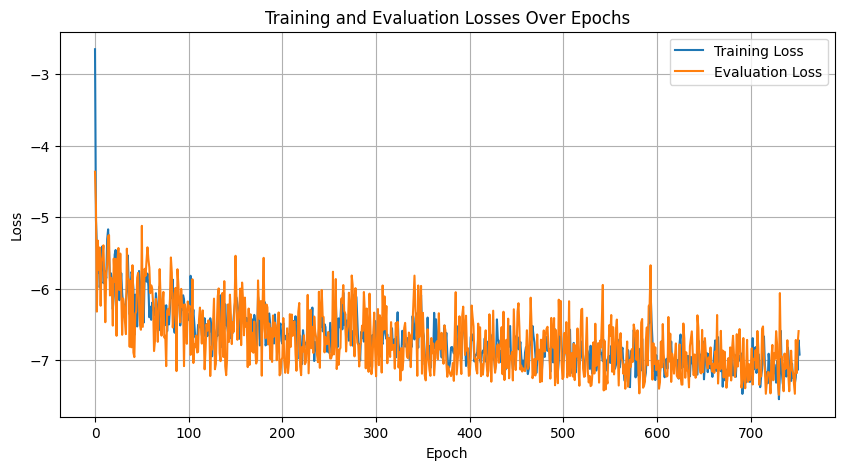

In [24]:
# Plotting the training and evaluation losses
plt.figure(figsize=(10, 5))
plt.plot(np.log(train_losses), label='Training Loss')
plt.plot(np.log(eval_losses), label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
import datetime
date = datetime.date.today()

In [29]:
# Save Python model

save_path =  '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/vehicle/{}_rotorSystem_customoss_lr{}_e{}_hidDim{}.pth'.format(date, LEARNING_RATE, EPOCHS, hidden_dim)
print("The model will be saved as the following:\n {}".format(save_path))


torch.save(composite_model.state_dict(), save_path)

The model will be saved as the following:
 /mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/vehicle/2025-02-06_rotorSystem_customoss_lr0.0002_e1000_hidDim100.pth


In [31]:
# Save Scripted model

save_path =  '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/vehicle/{}_scripted_rotorSystem_customoss_lr{}_e{}_hidDim{}.pt'.format(date, LEARNING_RATE, EPOCHS, hidden_dim)
print("The model will be saved as the following:\n {}".format(save_path))


torch.jit.save(scripted_model, save_path)

The model will be saved as the following:
 /mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/vehicle/2025-02-06_scripted_rotorSystem_customoss_lr0.0002_e1000_hidDim100.pt


## Test the model

In [25]:

def plot_model_vs_ground_truth(time, model_outputs, ground_truths, labels, save_csv=False, csv_filename="NN_predictions.csv"):
    """
    Plot model predictions vs ground truth for aerodynamic coefficients.
    Optionally saves the NN predictions to a CSV file.

    Args:
        time (array-like): Time steps.
        model_outputs (dict): Dictionary containing model predictions.
        ground_truths (dict): Dictionary containing ground truth values.
        labels (list): List of keys for extracting the values (e.g., ["Cl_1", "Cd_1", ..., "Cq_R4"]).
        save_csv (bool): If True, saves predictions to a CSV file.
        csv_filename (str): Name of the CSV file to save predictions.
    """
    num_plots = len(labels)  # Should be 20
    rows, cols = 4, 2  # Define subplot grid

    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()  # Convert to a 1D list for easy indexing

    # Create a dictionary to store CSV data
    csv_data = {"Time": time}

    for i, key in enumerate(labels):
        ax = axes[i]
        ax.plot(ground_truths[key], label="Ground Truth", linestyle='dashed', color='black')
        ax.plot(model_outputs[key], label="Model Prediction", linestyle='solid', color='blue')
        ax.set_title(key)
        ax.set_xlabel("Time")
        ax.set_ylabel("Coefficient Value")
        ax.legend()
        ax.grid(True)

        # Store data for CSV
        csv_data[f"{key}_NN"] = model_outputs[key]
        csv_data[f"{key}_Truth"] = ground_truths[key]

    # Remove empty subplots if `num_plots < rows*cols`
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Save predictions to CSV if enabled
    if save_csv:
        df = pd.DataFrame(csv_data)
        df.to_csv(csv_filename, index=False)
        print(f"Neural Network predictions saved to '{csv_filename}'")



Simulation Case: eMO_hover_v0_r1600


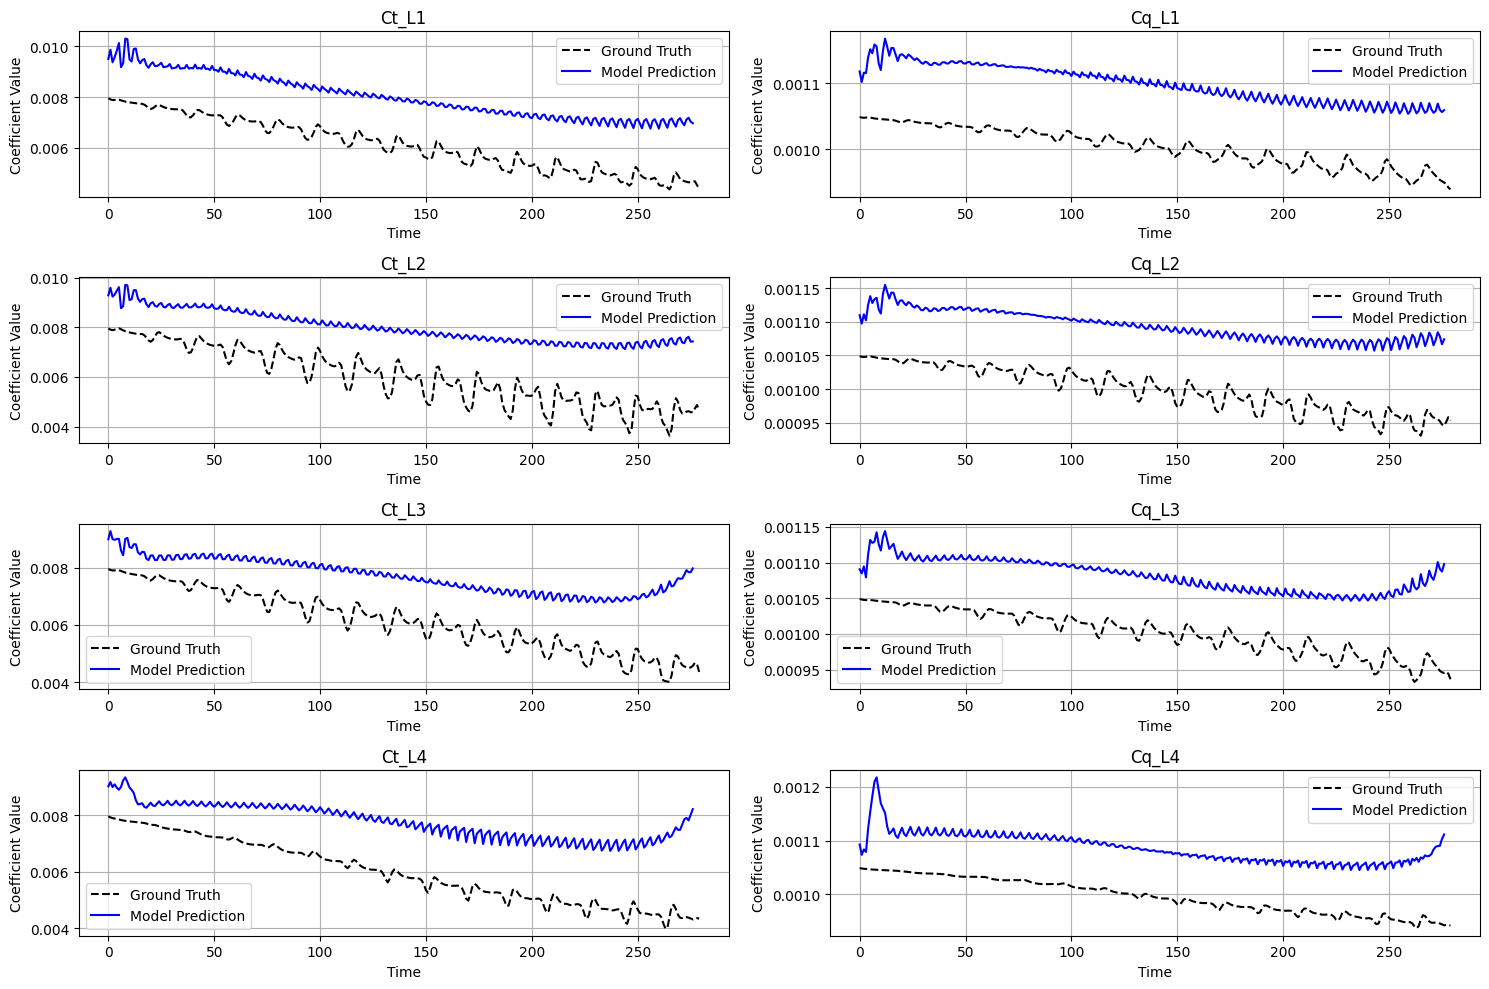

Simulation Case: eMO_hover_v10_r2200_a3


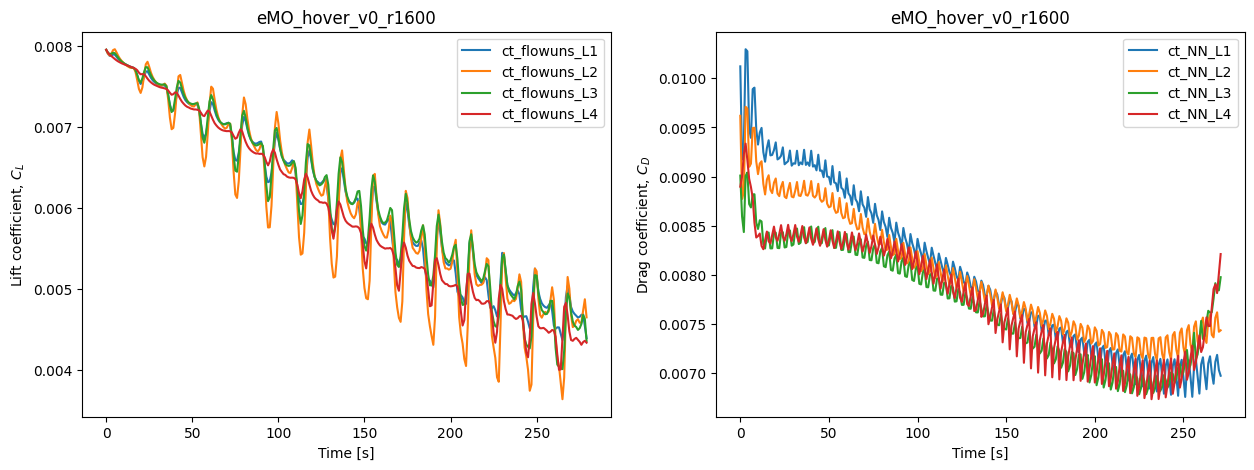

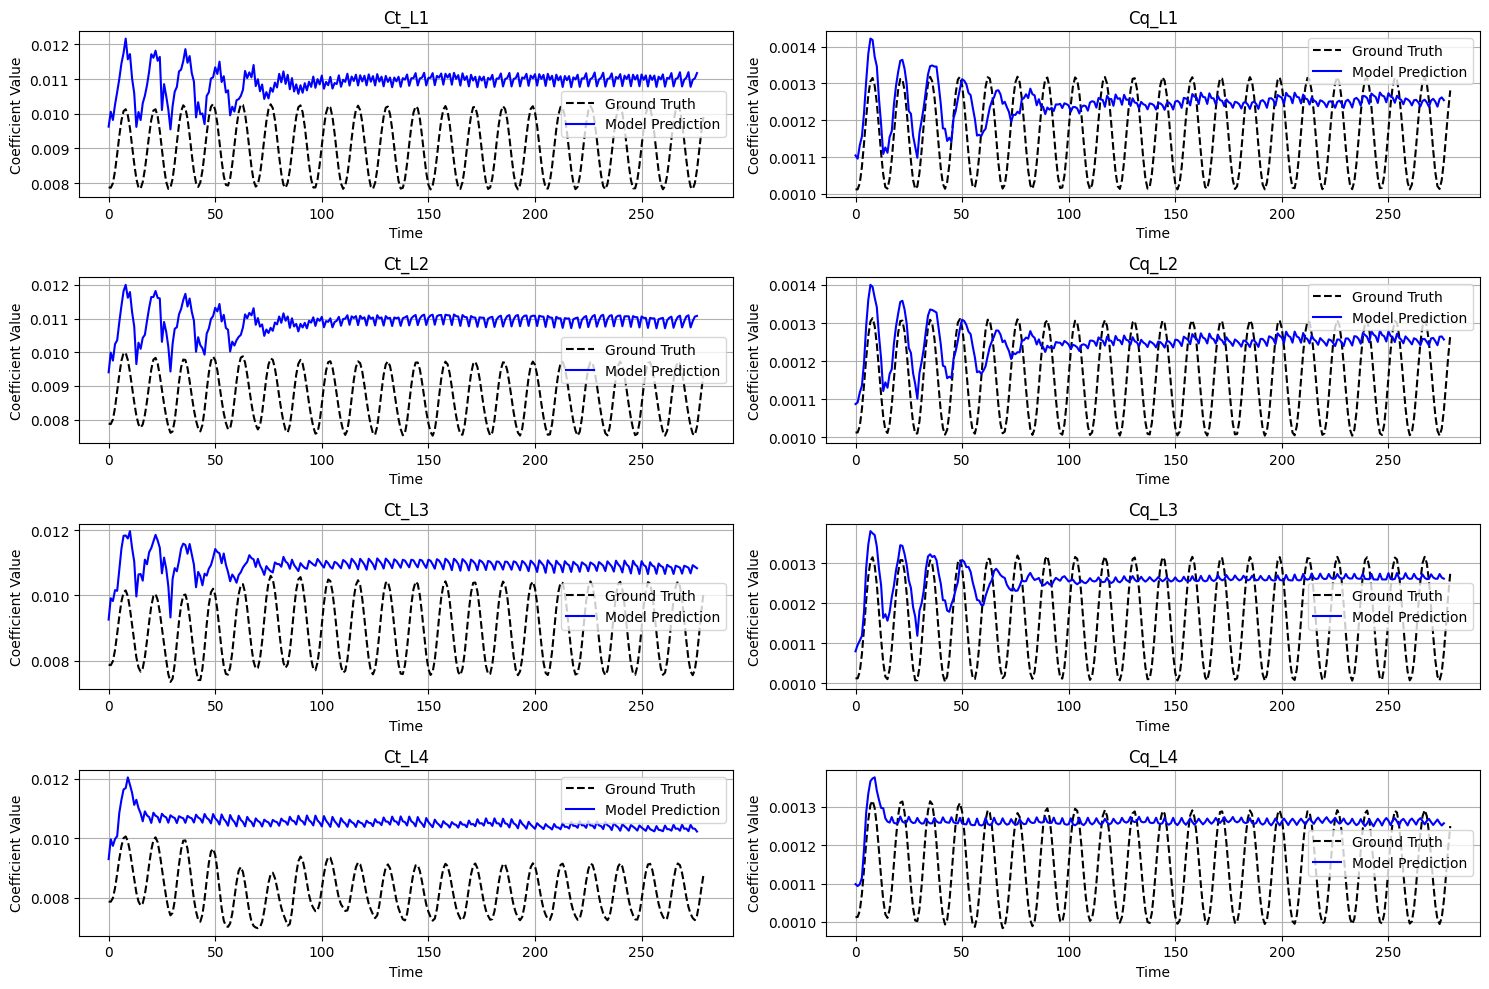

Simulation Case: eMO_hover_v12_r1600_a1


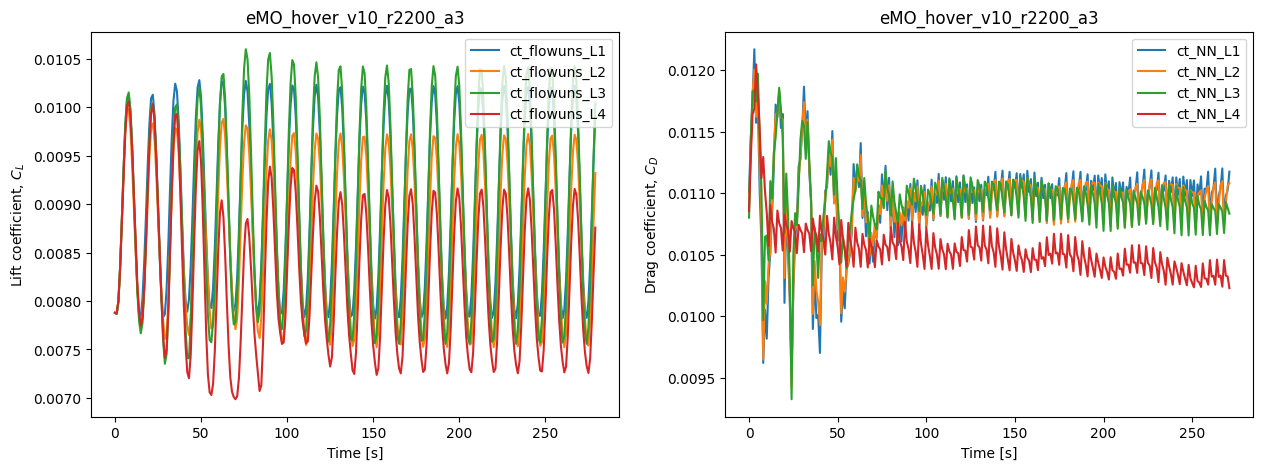

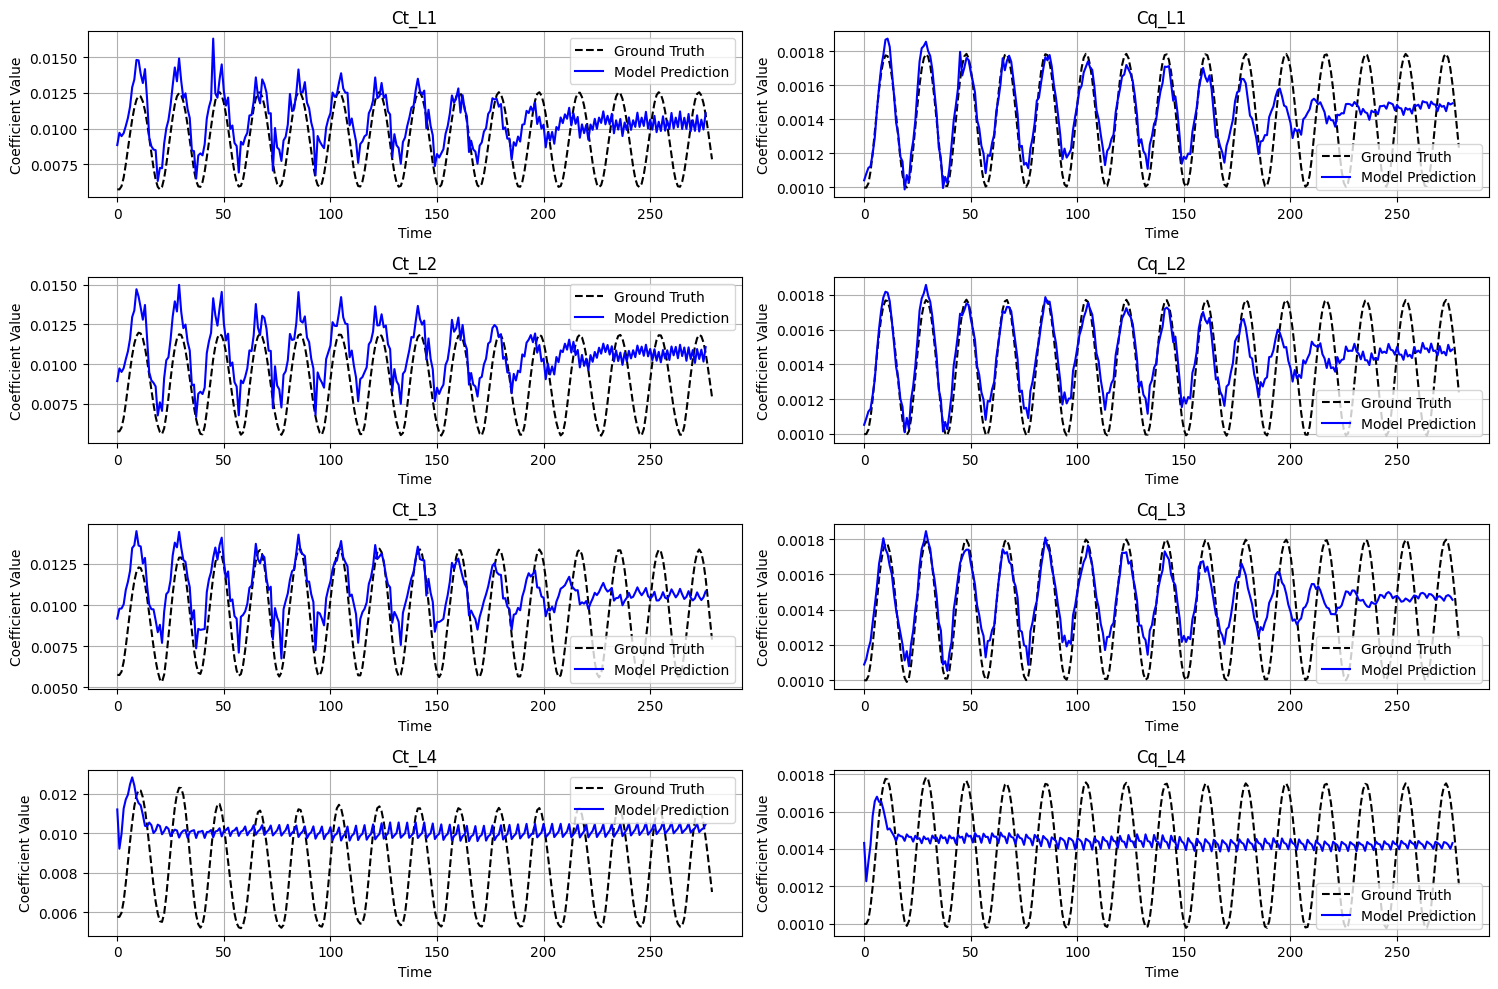

Simulation Case: eMO_hover_v12_r2000_a1


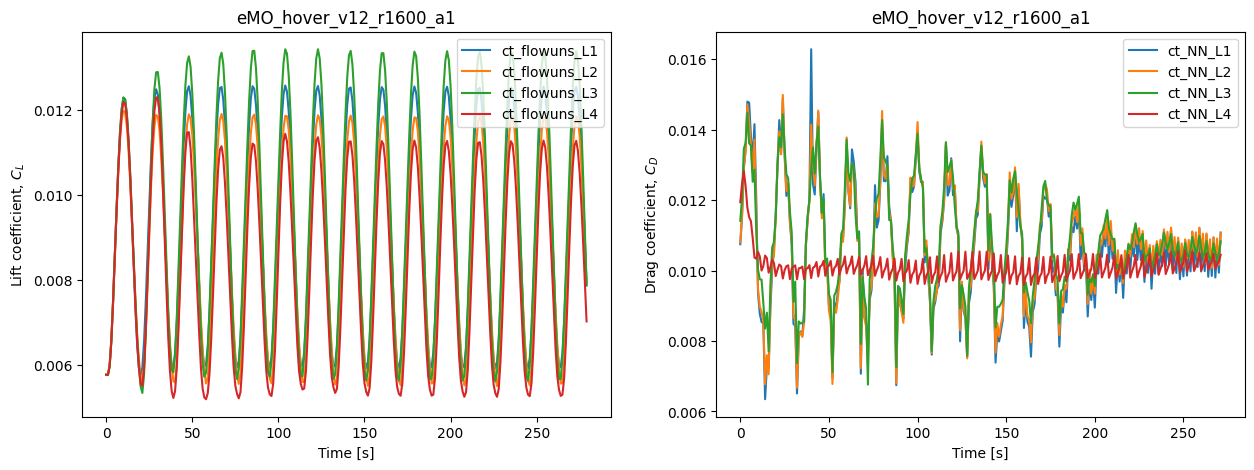

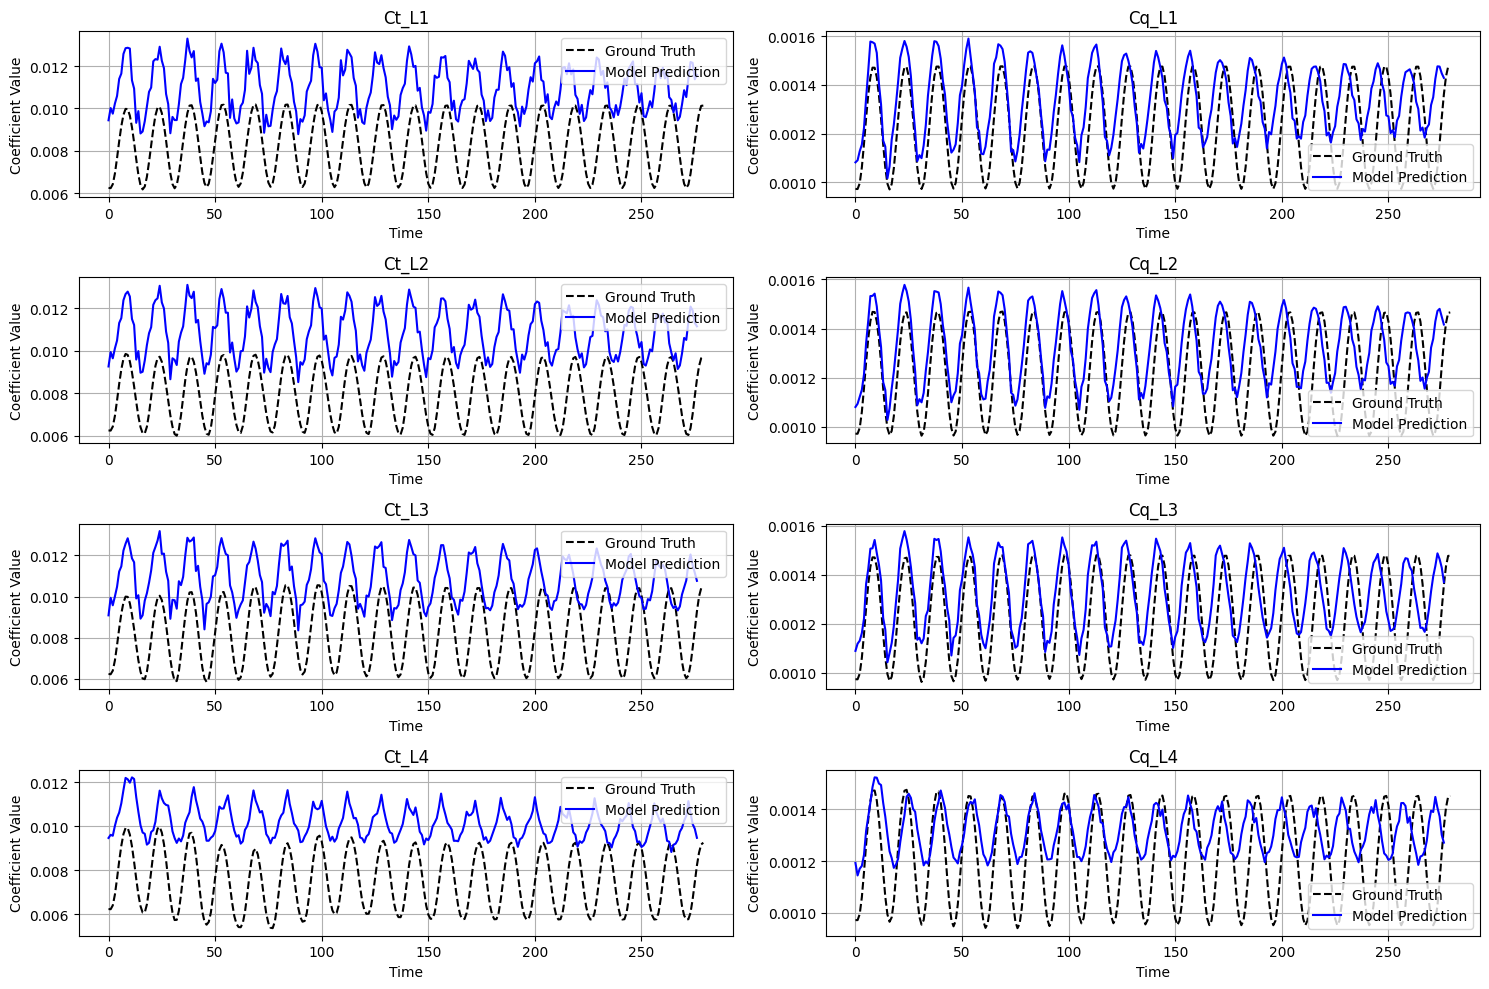

Simulation Case: eMO_hover_v2_r1600


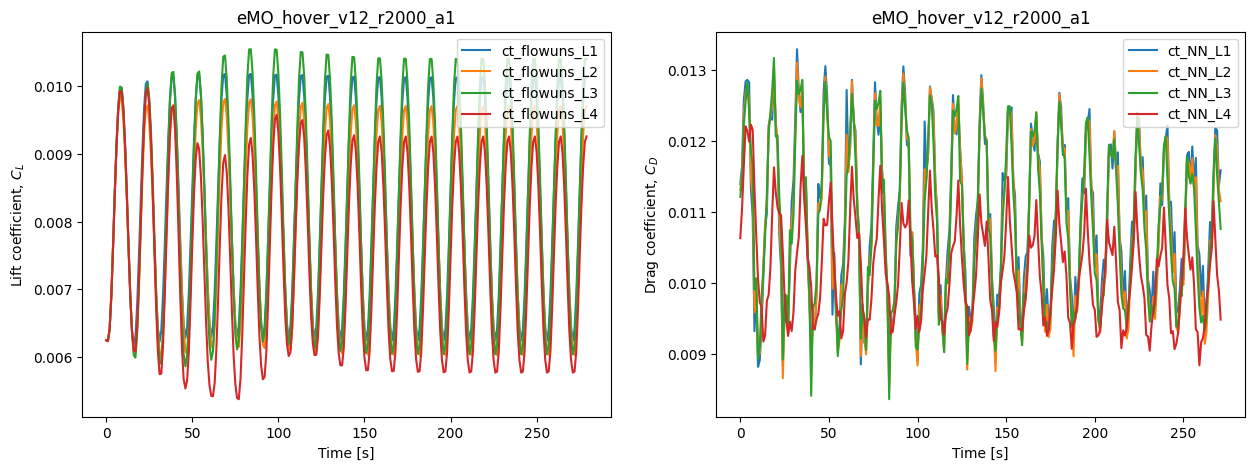

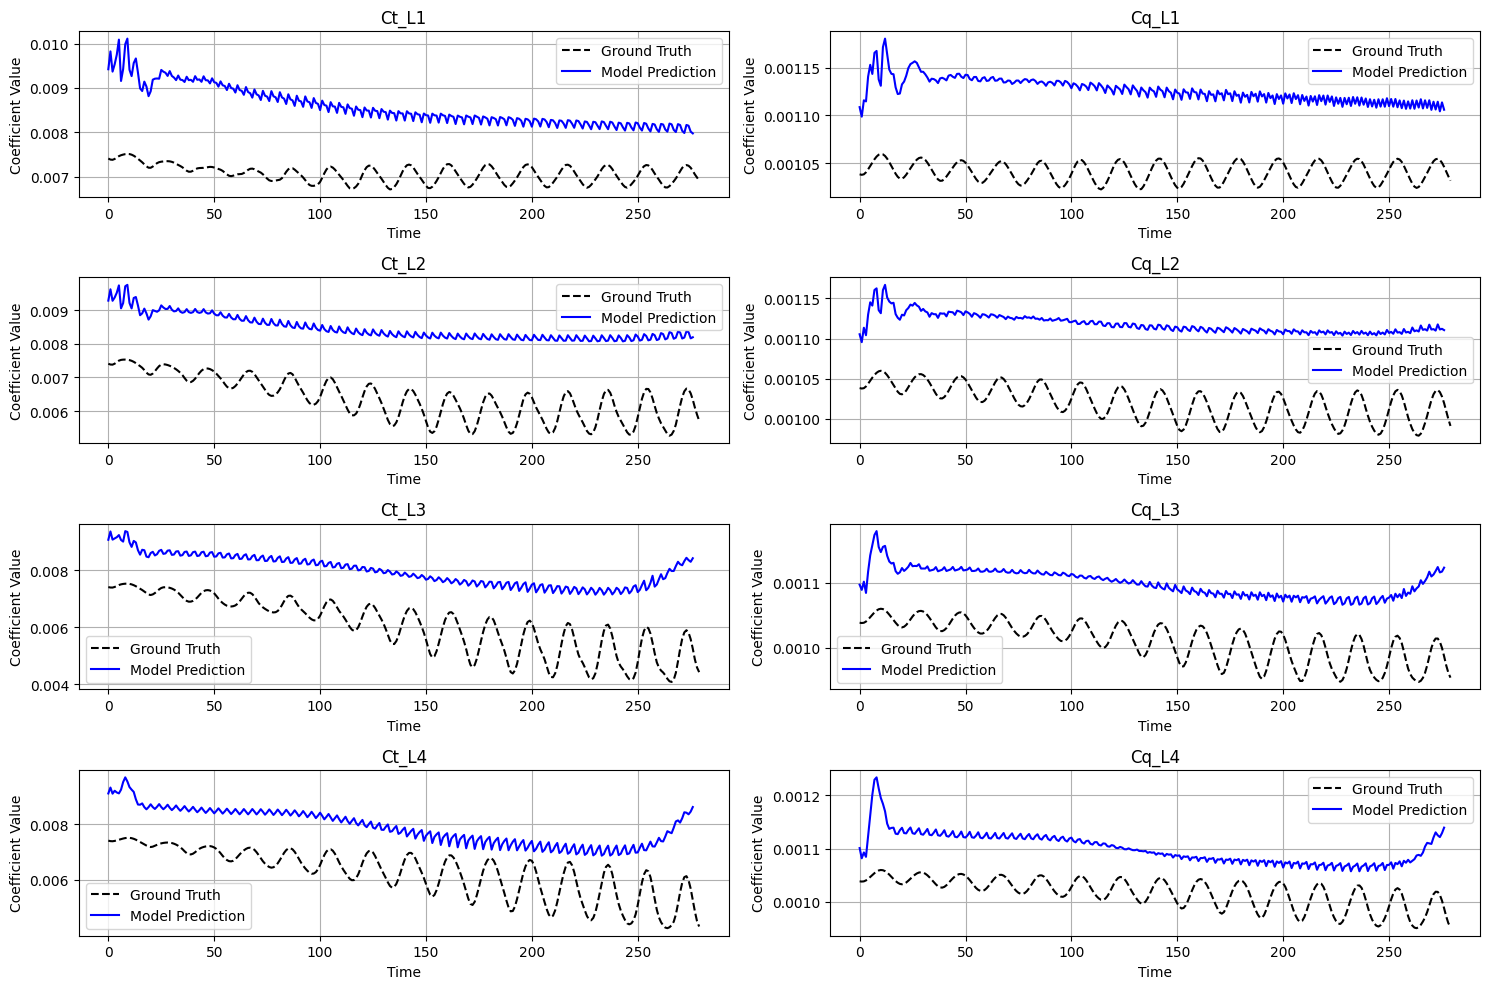

Simulation Case: eMO_hover_v4_r2000_a5


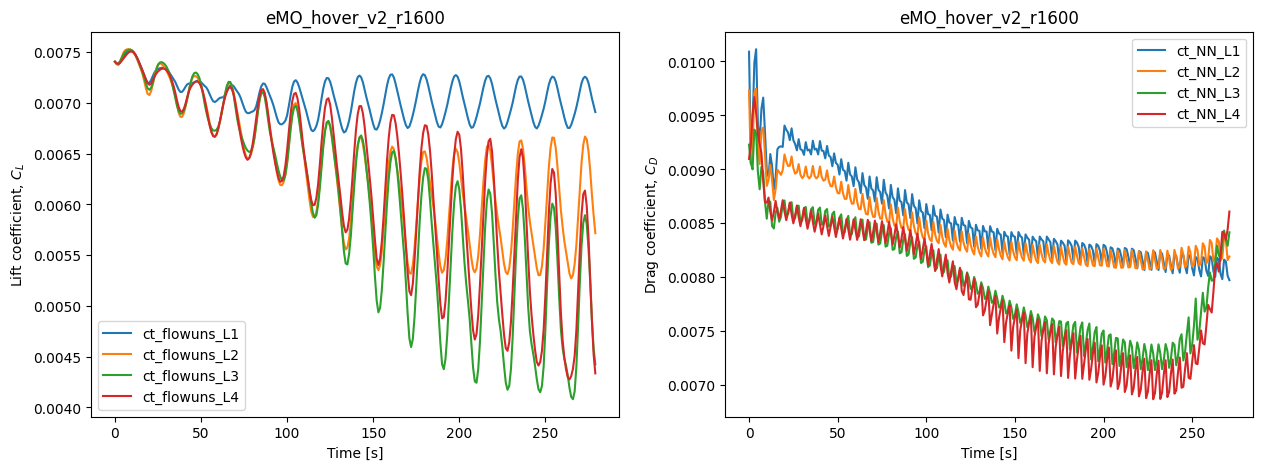

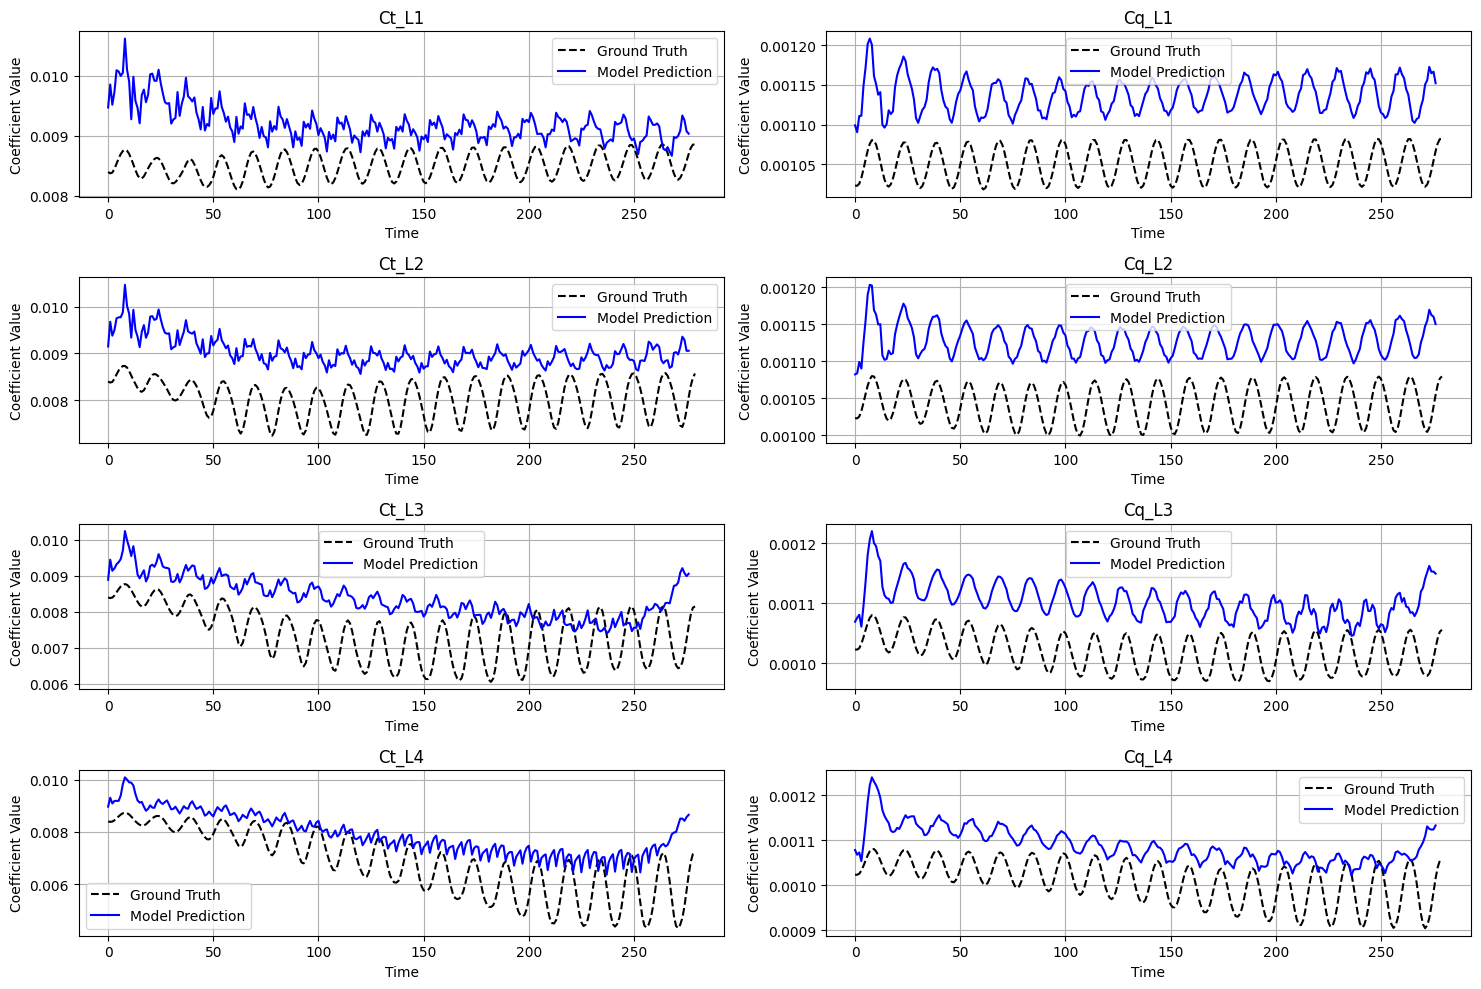

Simulation Case: eMO_hover_v5_r1800_a1


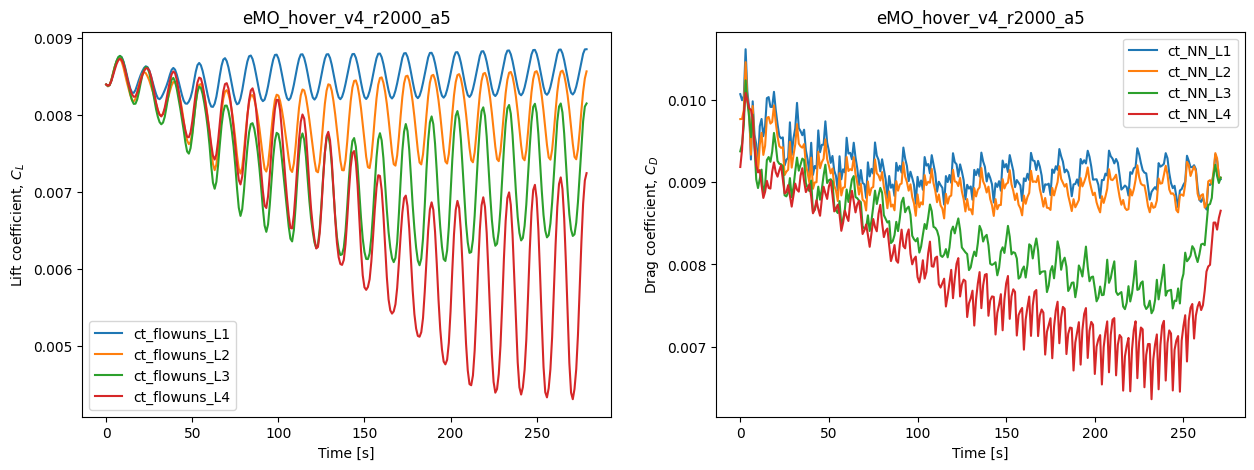

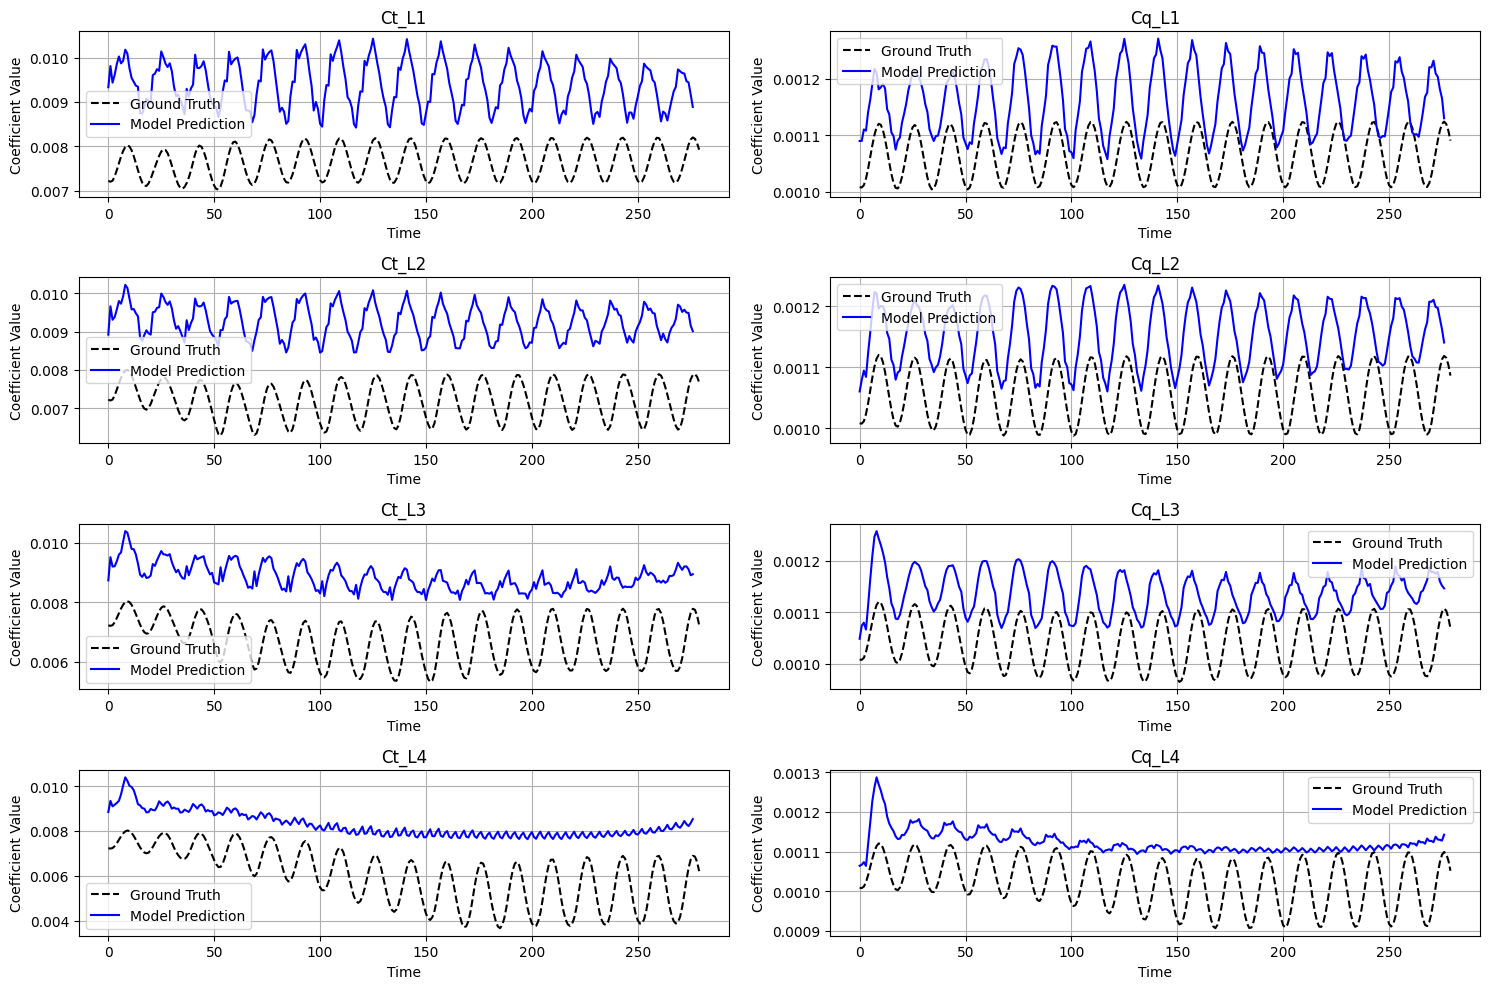

Simulation Case: eMO_hover_v6_r2000_a5


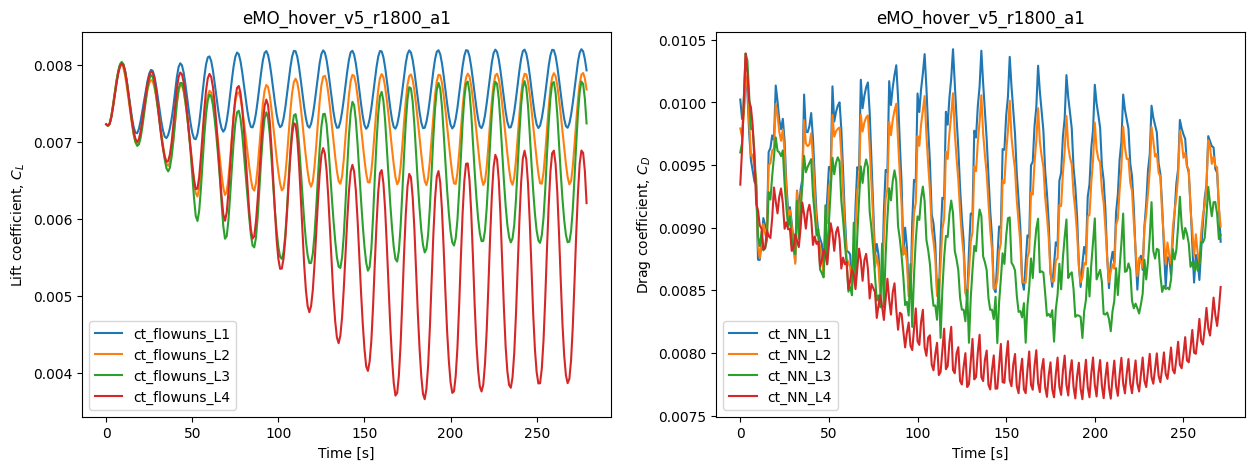

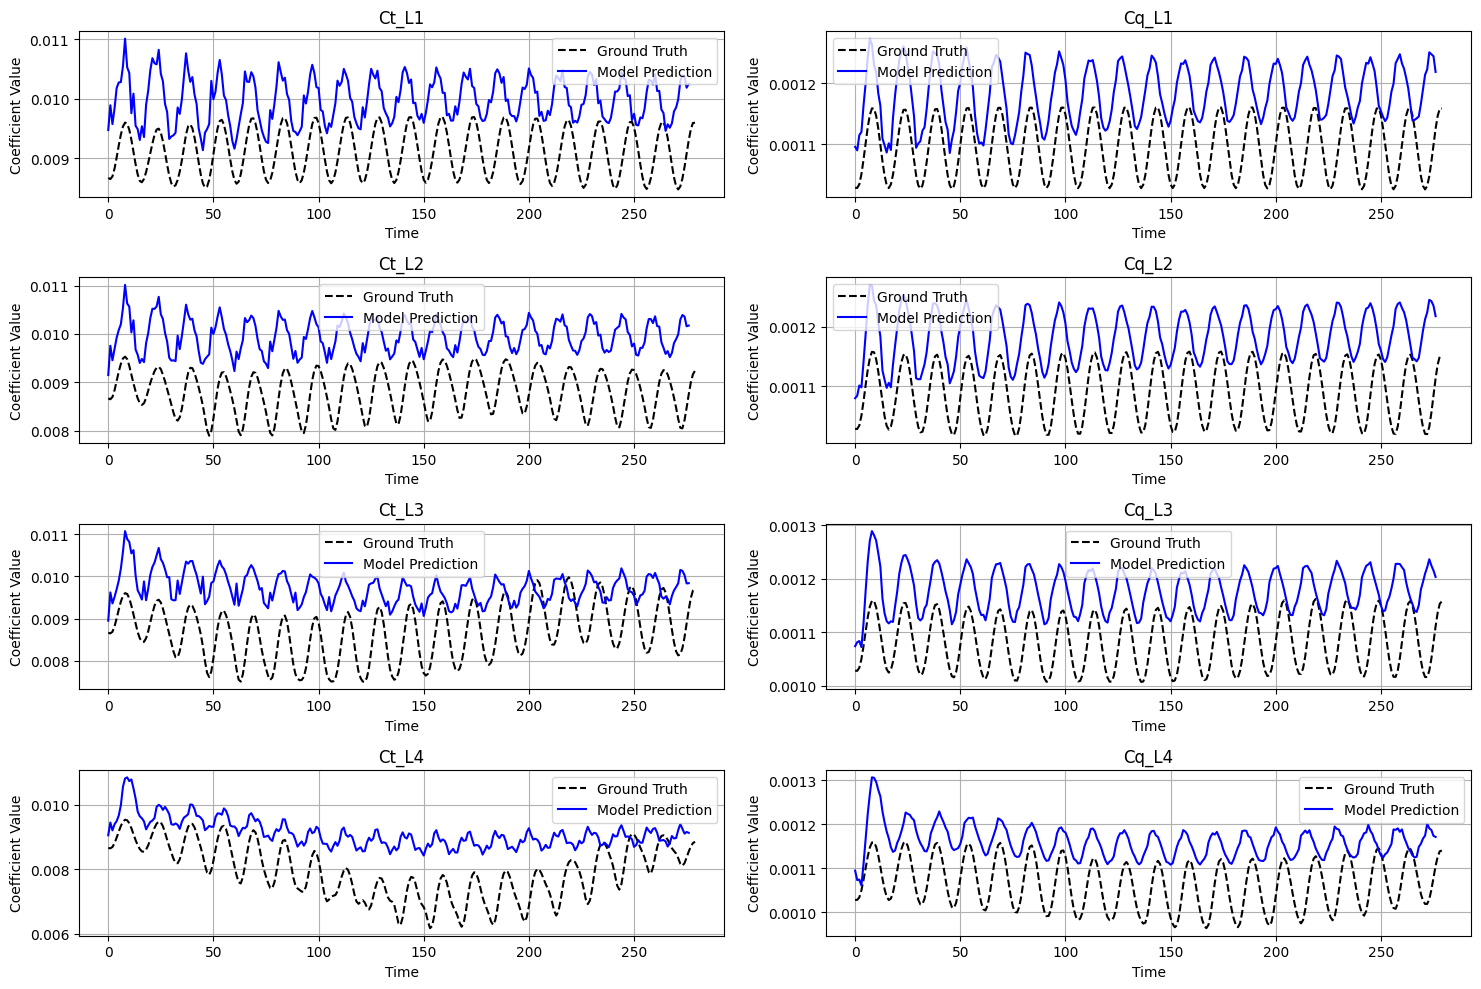

Simulation Case: eMO_hover_v8_r1800_a1


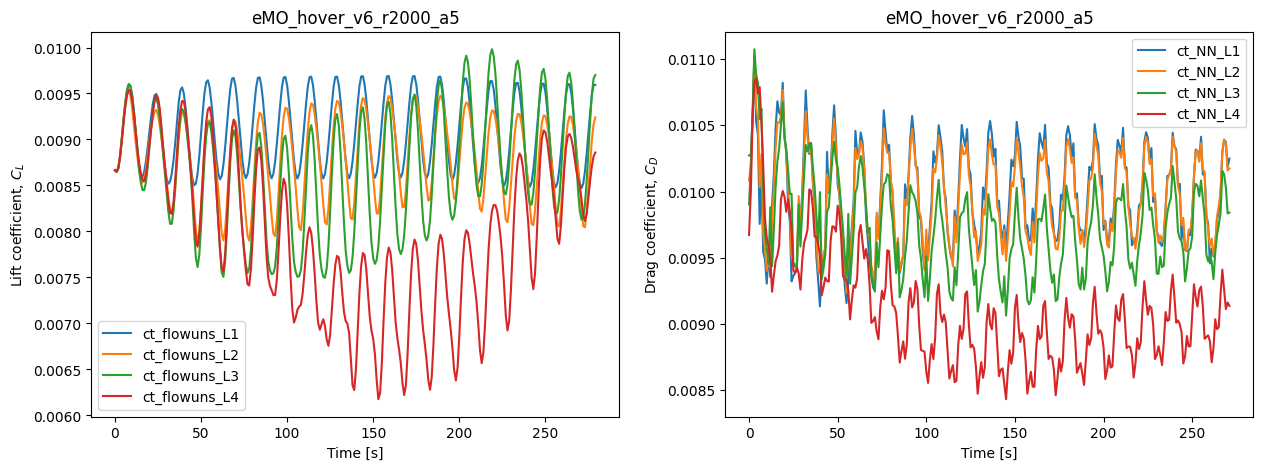

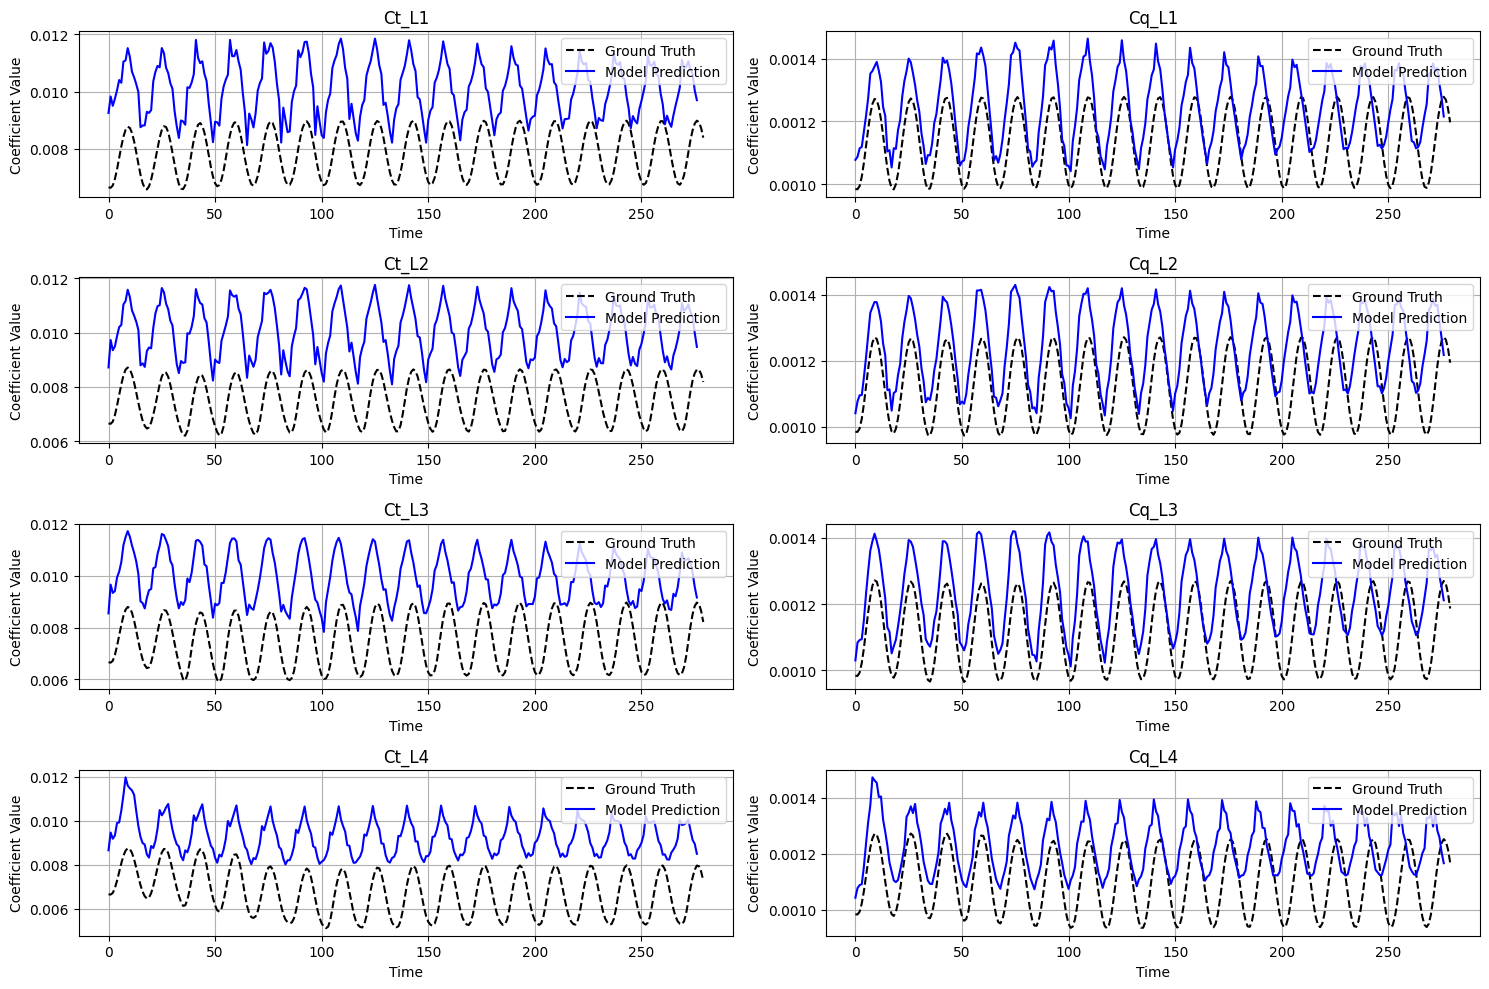

Simulation Case: eMO_hover_v8_r2000_a1


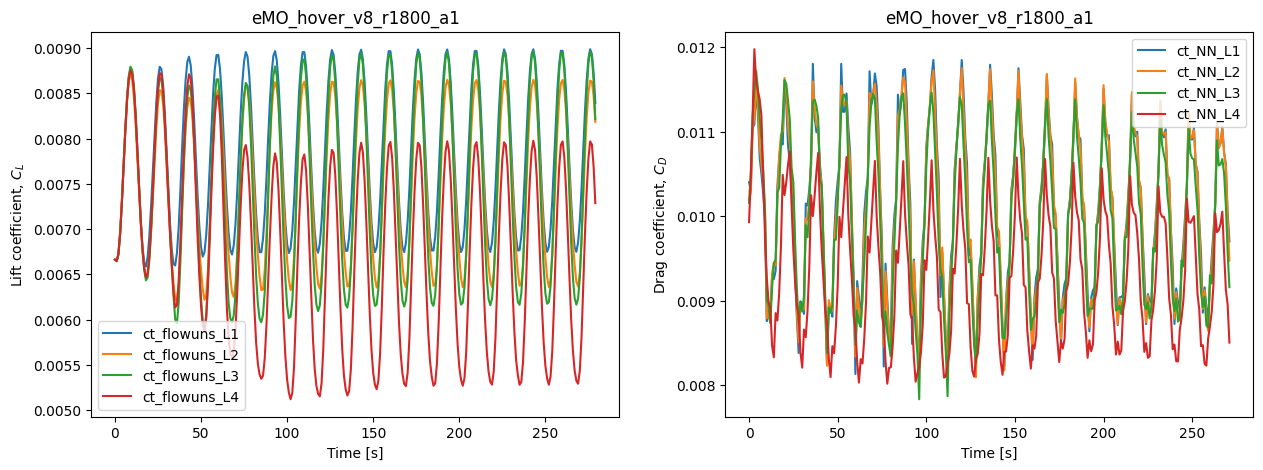

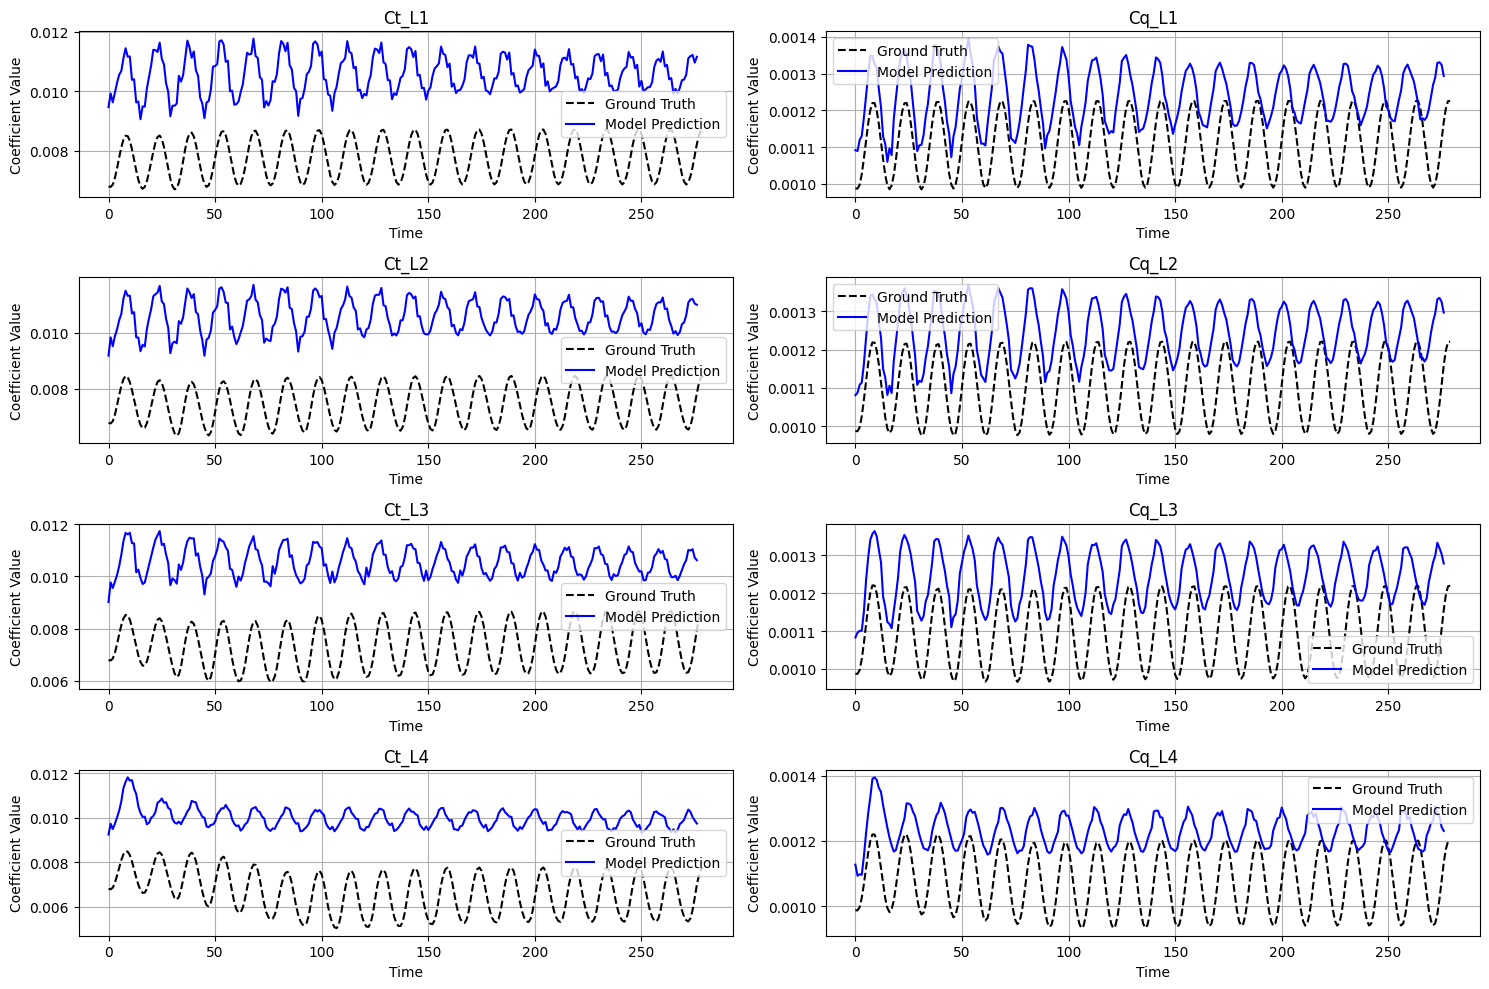

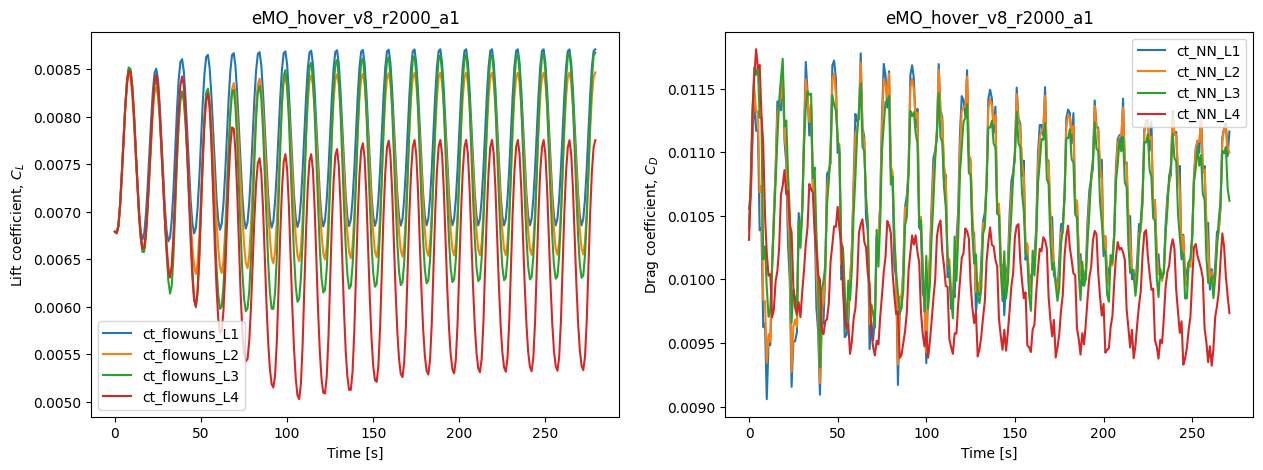

In [26]:
 
from sklearn.metrics import mean_squared_error 

root_test_base = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/aircraft_data/testing_data/'
batch_size_test = 1

for simulation_case in os.listdir(root_test_base):

    root_test_dir = root_test_base+simulation_case

    # Canard dataset
    dataset_canard_test = WingDataset(root_test_dir, 
                                    af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                                    af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                                    airfoil_cl=airfoil_cl, 
                                    airfoil_cd=airfoil_cd, 
                                    device=device,
                                    wing_name = 'Canard',     # select 'wing_main' or 'Canard'  
                                    subdir_condition=subdir_condition_wing)

    inputs_canard_test, outputs_canard_test = dataset_canard_test[0:]

    input_tensor_canard_test = inputs_canard_test
    input_tensor_canard_test = inputs_canard_test.squeeze(1)  # Reshaping
    # print("Input shape (Canard dataset):", input_tensor_canard.shape)
    output_tensor_canard_test = outputs_canard_test.squeeze(1)
    # print("Output shape (Canard dataset):",output_tensor_canard.shape)

    dataset_wing_test = WingDataset(root_test_dir, 
                                    af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                                    af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                                    airfoil_cl=airfoil_cl, 
                                    airfoil_cd=airfoil_cd, 
                                    device=device,
                                    wing_name = 'wing_main',     # select 'wing_main' or 'Canard'  
                                    subdir_condition=subdir_condition_wing)
    
    inputs_wing_test, outputs_wing_test = dataset_wing_test[0:]

    input_tensor_wing_test = inputs_wing_test
    input_tensor_wing_test = inputs_wing_test.squeeze(1)  # Reshaping
    # print("Input shape (Wing dataset):", input_tensor_wing.shape)
    output_tensor_wing_test = outputs_wing_test.squeeze(1)
    # print("Output shape (Wing dataset):",output_tensor_wing.shape)


    # dataset - Rotor L1
    dataset_rotor_L1_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL1_test, outputs_rL1_test = dataset_rotor_L1_test[0:]

    input_tensor_rL1_test = inputs_rL1_test.squeeze(1)  # Reshaping
    # print("Input shape (rotor - L1):", input_tensor_rL1.shape) 
    output_tensor_rL1_test = outputs_rL1_test.squeeze(1)
    # print("Output shape (rotor - L1):",output_tensor_rL1.shape)

    dataset_rotor_L2_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L2',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL2_test, outputs_rL2_test = dataset_rotor_L2_test[0:]

    input_tensor_rL2_test = inputs_rL2_test.squeeze(1)  # Reshaping
    output_tensor_rL2_test = outputs_rL2_test.squeeze(1)

    dataset_rotor_L3_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L3',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL3_test, outputs_rL3_test = dataset_rotor_L3_test[0:]

    input_tensor_rL3_test = inputs_rL3_test.squeeze(1)  # Reshaping
    output_tensor_rL3_test = outputs_rL3_test.squeeze(1)

    dataset_rotor_L4_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L4',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL4_test, outputs_rL4_test = dataset_rotor_L4_test[0:]

    input_tensor_rL4_test = inputs_rL4_test.squeeze(1)  # Reshaping
    output_tensor_rL4_test = outputs_rL4_test.squeeze(1)

    # dataset - Rotor R1
    dataset_rotor_R1_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR1_test, outputs_rR1_test = dataset_rotor_R1_test[0:]

    input_tensor_rR1_test = inputs_rR1_test.squeeze(1)  # Reshaping
    # print("Input shape (rotor - R1):", input_tensor_rR1.shape) 
    output_tensor_rR1_test = outputs_rR1_test.squeeze(1)
    # print("Output shape (rotor - R1):",output_tensor_rR1.shape) 

    dataset_rotor_R2_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R2',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR2_test, outputs_rR2_test = dataset_rotor_R2_test[0:]

    input_tensor_rR2_test = inputs_rR2_test.squeeze(1)  # Reshaping
    output_tensor_rR2_test = outputs_rR2_test.squeeze(1)

    dataset_rotor_R3_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R3',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR3_test, outputs_rR3_test = dataset_rotor_R3_test[0:]

    input_tensor_rR3_test = inputs_rR3_test.squeeze(1)  # Reshaping
    output_tensor_rR3_test = outputs_rR3_test.squeeze(1)

    dataset_rotor_R4_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R4',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR4_test, outputs_rR4_test = dataset_rotor_R4_test[0:]
    
    input_tensor_rR4_test = inputs_rR4_test.squeeze(1)  # Reshaping
    output_tensor_rR4_test = outputs_rR4_test.squeeze(1)

    dataset_aircraft_test = AircraftDataset(dataset_wing_test,
                                            dataset_canard_test,
                                            dataset_rotor_L1_test,
                                            dataset_rotor_L2_test,
                                            dataset_rotor_L3_test,
                                            dataset_rotor_L4_test,
                                            dataset_rotor_R1_test,
                                            dataset_rotor_R2_test,
                                            dataset_rotor_R3_test,
                                            dataset_rotor_R4_test,
                                            input_scaler_wing_stat, output_scaler_wing_stat,
                                            input_scaler_rotor_L1, output_scaler_rotor_L1,
                                            input_scaler_rotor_L2, output_scaler_rotor_L2,
                                            input_scaler_rotor_L3, output_scaler_rotor_L3,
                                            input_scaler_rotor_L4, output_scaler_rotor_L4)


    graph_dataset_test = GraphDataset(dataset_aircraft_test)

    graph_dataset_test = graph_dataset_test[0]

    node_inputs_test = (graph_dataset_test.x).to(device)
    edge_index_test = (graph_dataset_test.edge_index).to(device)
    edge_attr_test = (graph_dataset_test.edge_attr).to(device)
    global_inputs_test = (graph_dataset_test.global_input).to(device)
    targets_test = (graph_dataset_test.y).to(device)
    

    composite_model.eval()  # Set the model to evaluation mode


    with torch.no_grad():
        outputs_predicted = scripted_model(node_inputs_test, targets_test, edge_index_test,
                                             edge_attr_test, global_inputs_test,
                                             batch_size_test, num_nodes=4)

    
    
    outputs_predicted = outputs_predicted.cpu().detach().numpy()  # Convert tensor to numpy array
    outputs_predicted = outputs_predicted.squeeze(0)

    # predicted_outputs_wing = outputs_predicted[:, 0:2]
    # predicted_outputs_canard = outputs_predicted[:, 2:4]
    predicted_outputs_rotor_L1 = outputs_predicted[:, 0:2]
    # predicted_outputs_rotor_R1 = outputs_predicted[:, 6:8]
    predicted_outputs_rotor_L2 = outputs_predicted[:, 2:4]
    # predicted_outputs_rotor_R2 = outputs_predicted[:, 10:12]
    predicted_outputs_rotor_L3 = outputs_predicted[:, 4:6]
    # predicted_outputs_rotor_R3 = outputs_predicted[:, 14:16]
    predicted_outputs_rotor_L4 = outputs_predicted[:, 6:]
    # predicted_outputs_rotor_R4 = outputs_predicted[:, 18:20]
    
    # predicted_outputs_wing_og_scl = output_scaler_wing_stat.inverse_transform(predicted_outputs_wing)
    # predicted_outputs_canard_og_scl = output_scaler_wing_stat.inverse_transform(predicted_outputs_canard)
    predicted_outputs_rotor_L1_og_scl = output_scaler_rotor_L1.inverse_transform(predicted_outputs_rotor_L1)
    # predicted_outputs_rotor_R1_og_scl = output_scaler_rotor.inverse_transform(predicted_outputs_rotor_R1)
    predicted_outputs_rotor_L2_og_scl = output_scaler_rotor_L2.inverse_transform(predicted_outputs_rotor_L2)
    # predicted_outputs_rotor_R2_og_scl = output_scaler_rotor.inverse_transform(predicted_outputs_rotor_R2)
    predicted_outputs_rotor_L3_og_scl = output_scaler_rotor_L3.inverse_transform(predicted_outputs_rotor_L3)
    # predicted_outputs_rotor_R3_og_scl = output_scaler_rotor.inverse_transform(predicted_outputs_rotor_R3)
    predicted_outputs_rotor_L4_og_scl = output_scaler_rotor_L4.inverse_transform(predicted_outputs_rotor_L4)
    # predicted_outputs_rotor_R4_og_scl = output_scaler_rotor.inverse_transform(predicted_outputs_rotor_R4)

    # time_steps = time_steps.cpu().detach().numpy()
    time_steps = (global_inputs_test.squeeze(0))[:,0]
    time_steps = time_steps.cpu().detach().numpy()

    # Predictions from the Neural Network
    # cl_test_NN_wing = predicted_outputs_wing_og_scl[:, 0]
    # cd_test_NN_wing = predicted_outputs_wing_og_scl[:, 1]

    # cl_test_NN_canard = predicted_outputs_canard_og_scl[:, 0]
    # cd_test_NN_canard = predicted_outputs_canard_og_scl[:, 1]

    ct_test_NN_L1 = predicted_outputs_rotor_L1_og_scl[:, 0]
    cq_test_NN_L1 = predicted_outputs_rotor_L1_og_scl[:, 1]

    # ct_test_NN_R1 = predicted_outputs_rotor_R1_og_scl[:, 0]
    # cq_test_NN_R1 = predicted_outputs_rotor_R1_og_scl[:, 1]
    
    ct_test_NN_L2 = predicted_outputs_rotor_L2_og_scl[:, 0]
    cq_test_NN_L2 = predicted_outputs_rotor_L2_og_scl[:, 1]

    # ct_test_NN_R2 = predicted_outputs_rotor_R2_og_scl[:, 0]
    # cq_test_NN_R2 = predicted_outputs_rotor_R2_og_scl[:, 1]

    ct_test_NN_L3 = predicted_outputs_rotor_L3_og_scl[:, 0]
    cq_test_NN_L3 = predicted_outputs_rotor_L3_og_scl[:, 1]

    # ct_test_NN_R3 = predicted_outputs_rotor_R3_og_scl[:, 0]
    # cq_test_NN_R3 = predicted_outputs_rotor_R3_og_scl[:, 1]

    ct_test_NN_L4 = predicted_outputs_rotor_L4_og_scl[:, 0]
    cq_test_NN_L4 = predicted_outputs_rotor_L4_og_scl[:, 1]

    # ct_test_NN_R4 = predicted_outputs_rotor_R4_og_scl[:, 0]
    # cq_test_NN_R4 = predicted_outputs_rotor_R4_og_scl[:, 1]

    
    # FLOWUnsteady dataset
    # cl_test_flowuns_canard = dataset_canard_test.get_variable('CL')
    # cd_test_flowuns_canard = dataset_canard_test.get_variable('CD')
    # cl_test_flowuns_wing = dataset_wing_test.get_variable('CL')
    # cd_test_flowuns_wing = dataset_wing_test.get_variable('CD')
    ct_test_flowuns_L1 = dataset_rotor_L1_test.get_variable('CT')
    cq_test_flowuns_L1 = dataset_rotor_L1_test.get_variable('CQ')
    ct_test_flowuns_L2 = dataset_rotor_L2_test.get_variable('CT')
    cq_test_flowuns_L2 = dataset_rotor_L2_test.get_variable('CQ')
    ct_test_flowuns_L3 = dataset_rotor_L3_test.get_variable('CT')
    cq_test_flowuns_L3 = dataset_rotor_L3_test.get_variable('CQ')
    ct_test_flowuns_L4 = dataset_rotor_L4_test.get_variable('CT')
    cq_test_flowuns_L4 = dataset_rotor_L4_test.get_variable('CQ')
    # ct_test_flowuns_R1 = dataset_rotor_R1_test.get_variable('CT')
    # cq_test_flowuns_R1 = dataset_rotor_R1_test.get_variable('CQ')
    # ct_test_flowuns_R2 = dataset_rotor_R2_test.get_variable('CT')
    # cq_test_flowuns_R2 = dataset_rotor_R2_test.get_variable('CQ')
    # ct_test_flowuns_R3 = dataset_rotor_R3_test.get_variable('CT')
    # cq_test_flowuns_R3 = dataset_rotor_R3_test.get_variable('CQ')
    # ct_test_flowuns_R4 = dataset_rotor_R4_test.get_variable('CT')
    # cq_test_flowuns_R4 = dataset_rotor_R4_test.get_variable('CQ')

    model_outputs = {
        # "Cl_Wing": cl_test_NN_wing,
        # "Cd_Wing": cd_test_NN_wing,
        # "Cl_Canard": cl_test_NN_canard,
        # "Cd_Canard": cd_test_NN_canard,
        "Ct_L1": ct_test_NN_L1,
        "Cq_L1": cq_test_NN_L1,
        "Ct_L2": ct_test_NN_L2,
        "Cq_L2": cq_test_NN_L2,
        "Ct_L3": ct_test_NN_L3,
        "Cq_L3": cq_test_NN_L3,
        "Ct_L4": ct_test_NN_L4,
        "Cq_L4": cq_test_NN_L4,
        # "Ct_R1": ct_test_NN_R1,
        # "Cq_R1": cq_test_NN_R1,
        # "Ct_R2": ct_test_NN_R2,
        # "Cq_R2": cq_test_NN_R2,
        # "Ct_R3": ct_test_NN_R3,
        # "Cq_R3": cq_test_NN_R3,
        # "Ct_R4": ct_test_NN_R4,
        # "Cq_R4": cq_test_NN_R4,
    }

    ground_truths = {
        # "Cl_Wing": cl_test_flowuns_wing[0],
        # "Cd_Wing": cd_test_flowuns_wing[0],
        # "Cl_Canard": cl_test_flowuns_canard[0],
        # "Cd_Canard": cd_test_flowuns_canard[0],
        "Ct_L1": ct_test_flowuns_L1[0],
        "Cq_L1": cq_test_flowuns_L1[0],
        "Ct_L2": ct_test_flowuns_L2[0],
        "Cq_L2": cq_test_flowuns_L2[0],
        "Ct_L3": ct_test_flowuns_L3[0],
        "Cq_L3": cq_test_flowuns_L3[0], 
        "Ct_L4": ct_test_flowuns_L4[0],
        "Cq_L4": cq_test_flowuns_L4[0],
        # "Ct_R1": ct_test_flowuns_R1[0],
        # "Cq_R1": cq_test_flowuns_R1[0],
        # "Ct_R2": ct_test_flowuns_R2[0],
        # "Cq_R2": cq_test_flowuns_R2[0],
        # "Ct_R3": ct_test_flowuns_R3[0],
        # "Cq_R3": cq_test_flowuns_R3[0],
        # "Ct_R4": ct_test_flowuns_R4[0],
        # "Cq_R4": cq_test_flowuns_R4[0],
    }

    # List of labels for plotting
    labels = list(model_outputs.keys())  # Ensures ordering matches

    print("Simulation Case:", simulation_case)  

    save_path = root_test_dir + simulation_case + '_NN_predictions.csv'
    plot_model_vs_ground_truth(time_steps, model_outputs, ground_truths, labels, save_csv=False, csv_filename=save_path)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ct_test_flowuns_L1[0], label = 'ct_flowuns_L1')
    plt.plot(ct_test_flowuns_L2[0], label = 'ct_flowuns_L2')
    plt.plot(ct_test_flowuns_L3[0], label = 'ct_flowuns_L3')
    plt.plot(ct_test_flowuns_L4[0], label = 'ct_flowuns_L4')
    plt.xlabel('Time [s]')
    plt.ylabel('Lift coefficient, $C_L$')
    plt.title(simulation_case)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(ct_test_NN_L1[5:], label = 'ct_NN_L1')
    plt.plot(ct_test_NN_L2[5:], label = 'ct_NN_L2')
    plt.plot(ct_test_NN_L3[5:], label = 'ct_NN_L3')
    plt.plot(ct_test_NN_L4[5:], label = 'ct_NN_L4')
    plt.xlabel('Time [s]')
    plt.ylabel('Drag coefficient, $C_D$')
    plt.title(simulation_case)
    plt.legend()


    # plt.figure(figsize=(15, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(ct_test_NN_L1[5:], label = 'ct_NN')
    # plt.plot((ct_test_flowuns_L1[0][5:]), label = 'ct_flowuns')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Thrust coefficient, $C_T$')
    # plt.title(simulation_case)
    # plt.legend()

    # plt.subplot(1, 2, 2)
    # plt.plot(cq_test_NN_L1[5:], label = 'cq_NN')
    # plt.plot(cq_test_flowuns_L1[0][5:], label = 'cq_flowuns')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Torque coefficient, $C_Q$')
    # plt.title(simulation_case)
    # plt.legend()

    # plt.figure(figsize=(15, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(ct_test_NN_R1[5:], label = 'ct_NN')
    # plt.plot((ct_test_flowuns_R1[0][5:]), label = 'ct_flowuns')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Thrust coefficient, $C_T$')
    # plt.title(simulation_case)
    # plt.legend()

    # plt.subplot(1, 2, 2)
    # plt.plot(cq_test_NN_R1[5:], label = 'cq_NN')
    # plt.plot(cq_test_flowuns_R1[0][5:], label = 'cq_flowuns')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Torque coefficient, $C_Q$')
    # plt.title(simulation_case)
    # plt.legend()





    